## <span style='font-family:Georgia'> Homework 10. - competition
    
*Authors: Elżbieta Jowik, Mateusz Wójcik*

In [12]:
%config Completer.use_jedi = False

import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import k_means
from sklearn.metrics import silhouette_score

# auxiliary functions
from snars_p10 import prepare_laplacian, get_features

plt.rcParams["figure.figsize"] = (8,10)

In [52]:
def generate_adjacency(df: pd.DataFrame) -> np.array:
    return df.to_numpy()


def plot_graph(adjacency_matrix: np.array, labels=None) -> None:
    G = nx.convert_matrix.from_numpy_array(adjacency_matrix)
    if labels is not None:
        nx.draw_networkx(
            G,
            nx.spring_layout(G, iterations=10000, seed=123),
            with_labels=False,
            node_size=100,
            ax=plt.subplots(figsize=(12, 8))[1],
            node_color=labels,
        )
        return

    nx.draw_networkx(
        G,
        nx.spring_layout(G, iterations=10000, seed=123),
        with_labels=False,
        node_size=50,
        ax=plt.subplots(figsize=(12, 8))[1],
    )


def detect_communities(adjacency_matrix: np.array, k: int):
    L = prepare_laplacian(adjacency_matrix)
    features = pd.DataFrame(np.real(get_features(L, k=k)))
    labels = k_means(features, k)[1]
    features["labels"] = labels
    return labels


# def prepare_laplacian(A: np.matrix) -> np.matrix:
#     """Given an adjacency matrix, computes the laplacian matrix"""
#     return A - np.diag(A.sum(axis=0))

# def get_features(L: np.matrix, k: int) -> np.matrix:
#     """Given a Laplacian matrix, return the feature vector based on eigenvalues"""
#     eigval, eigvect = np.linalg.eig(L)
#     K_largest_eigvals_indices = np.argsort(-np.real(eigval))[:k]
#     return eigvect[:, K_largest_eigvals_indices]

def find_optimal_k(adjacency_matrix, max_k, n):
    assert n <= max_k
    L = prepare_laplacian(adjacency_matrix)
    range_n_clusters = np.arange(2, max_k)
    silhouette_avg = []

    for k in range_n_clusters:
        features = pd.DataFrame(np.real(get_features(L, k=k)))
        cluster_labels = k_means(features, k)[1]

        # silhouette score
        silhouette_avg.append(silhouette_score(features, cluster_labels))
        
    # plot
    plt.plot(range_n_clusters, silhouette_avg,'bx-')    
    plt.xlabel('Values of k') 
    plt.ylabel('Silhouette score') 
    plt.title('Silhouette analysis for optimal k')
    plt.show()
    return 2 + np.argsort(silhouette_avg)[::-1][:n]

In [53]:
import itertools
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities

In [54]:
D1K2 = pd.read_csv("./data/competition/D1-K=2.csv", header=None)
D1UNC = pd.read_csv("./data/competition/D1-UNC.csv", header=None)
D2K7 = pd.read_csv("./data/competition/D2-K=7.csv", header=None)
D2UNC = pd.read_csv("./data/competition/D2-UNC.csv", header=None)
D3K12 = pd.read_csv("./data/competition/D3-K=12.csv", header=None)
D3UNC = pd.read_csv("./data/competition/D3-UNC.csv", header=None)

### <span style='font-family:Georgia'> D1-K=2

In [55]:
D1K2_results = {}

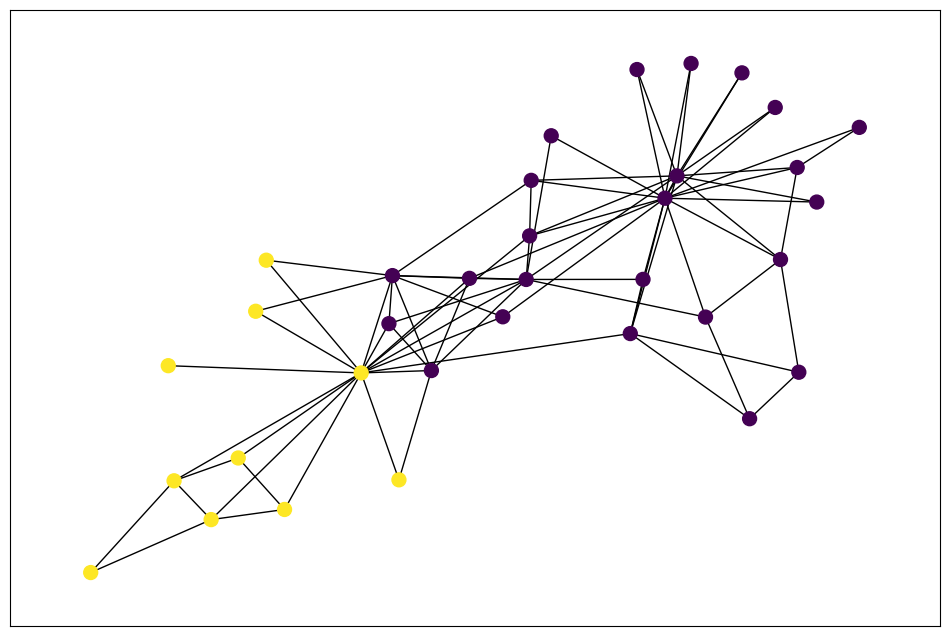

In [56]:
D1K2_adj = generate_adjacency(D1K2)
D1K2_labels = detect_communities(D1K2_adj, 2)
D1K2_results["laplace"] = D1K2_labels + 1
plot_graph(D1K2_adj, D1K2_labels)

([0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17], [2, 8, 9, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])


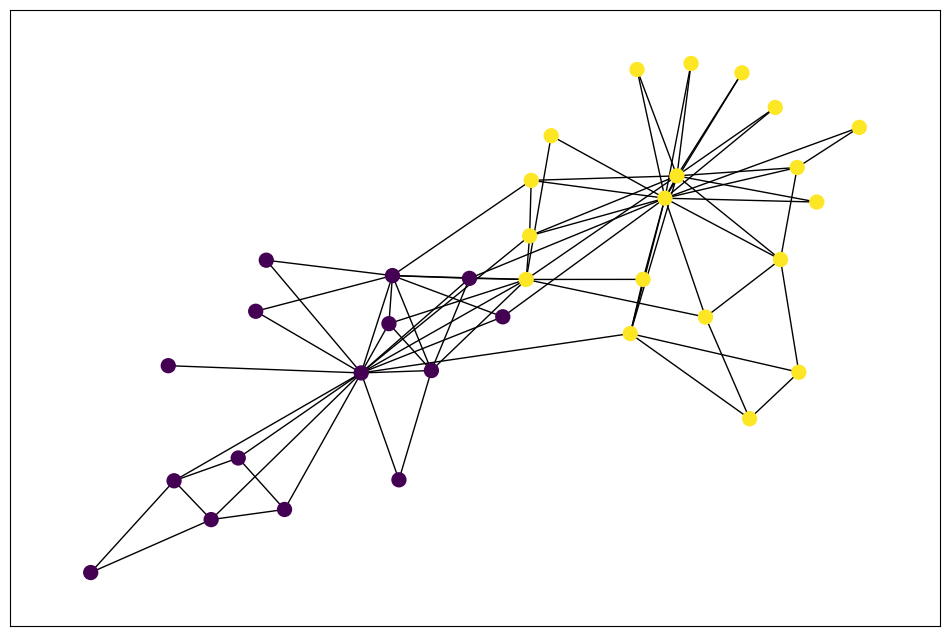

In [68]:
# %%timeit
# 647 ms ± 7.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
K = 2
G = nx.convert_matrix.from_numpy_array(generate_adjacency(D1K2))
communities_generator = community.girvan_newman(G)
for communities in itertools.islice(communities_generator, K-1):
    grouped_labels = tuple(sorted(c) for c in communities)
    print(grouped_labels)

D1K2_labels = np.zeros(len(G))
for k, com in enumerate(grouped_labels):
    for idx in com:
        D1K2_labels[idx] = k + 1
D1K2_results["girvan_newman"] = np.array([int(i) for i in D1K2_labels])
plot_graph(D1K2_adj, D1K2_labels)

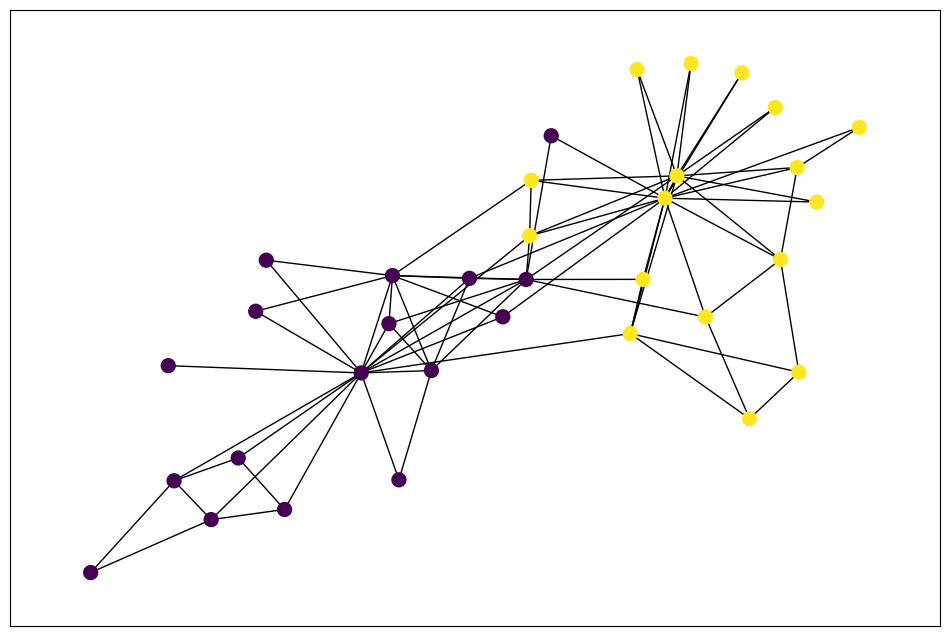

In [59]:
c = greedy_modularity_communities(G, best_n=K)
grouped_labels = [sorted(c[k]) for k in range(len(c))]

D1K2_labels = np.zeros(len(G))
for k, com in enumerate(grouped_labels):
    for idx in com:
        D1K2_labels[idx] = k + 1
D1K2_results["greedy_modularity_communitites"] = np.array([int(i) for i in D1K2_labels])
plot_graph(D1K2_adj, D1K2_labels)

In [60]:
community.louvain_communities(G, seed=123)

[{0, 1, 2, 3, 7, 9, 11, 12, 13, 15, 16, 17},
 {4, 5, 6, 10, 14},
 {18, 19, 20, 21, 22, 26},
 {8, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33}]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 25]
[9, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33]


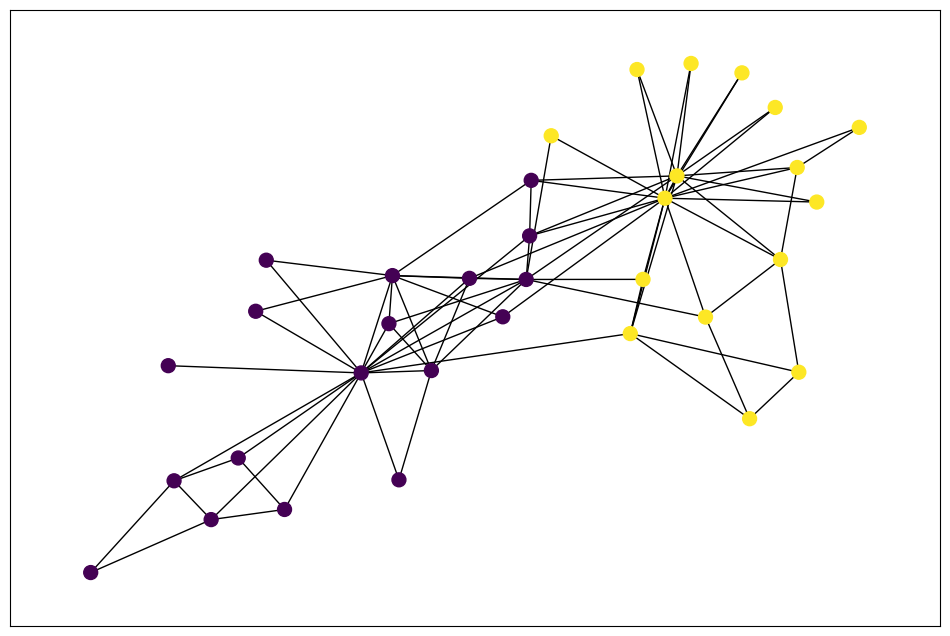

In [61]:
communities = community.asyn_fluidc(G, K)
grouped_labels = []
for k in range(K):
    com = sorted(next(communities))
    grouped_labels.append(com)
    print(com)
    
D1K2_labels = np.zeros(len(G))
for k, com in enumerate(grouped_labels):
    for idx in com:
        D1K2_labels[idx] = k + 1
        
D1K2_results["async_fluid"] = np.array([int(i) for i in D1K2_labels])
plot_graph(D1K2_adj, D1K2_labels)

In [62]:
D1K2_results

{'laplace': array([1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 'girvan_newman': array([1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 'greedy_modularity_communitites': array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 'async_fluid': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2])}

In [66]:
D1K2_df = pd.DataFrame({"x": range(1, len(G) + 1), "y": D1K2_results["girvan_newman"]})
D1K2_df.head()
D1K2_df.to_csv("results/D1-K=2.csv", header=False, index=False)

### <span style='font-family:Georgia'> D1-UNC

In [90]:
D1UNC_results = {}

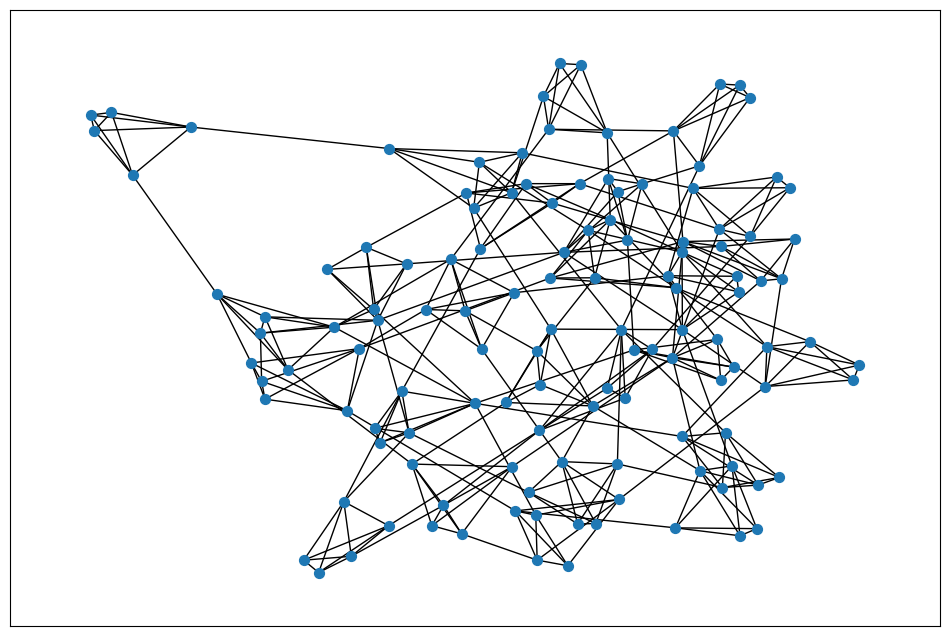

In [91]:
D1UNC_adj = generate_adjacency(D1UNC)
plot_graph(D1UNC_adj)

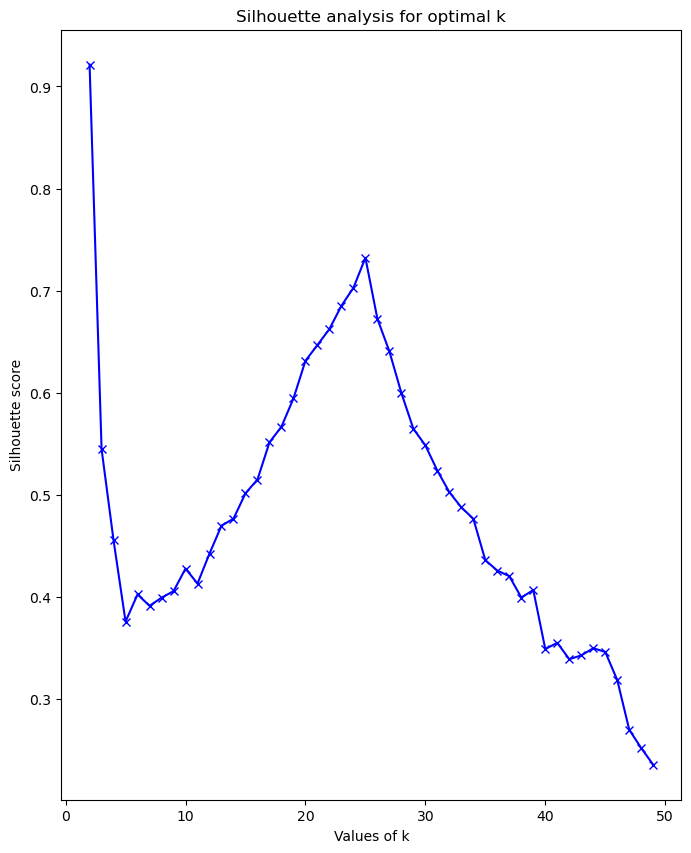

array([ 2, 25, 24, 23, 26])

In [92]:
find_optimal_k(D1UNC_adj, 50, 5)

In [93]:
K = 26
D1UNC_labels = detect_communities(D1UNC_adj, K)

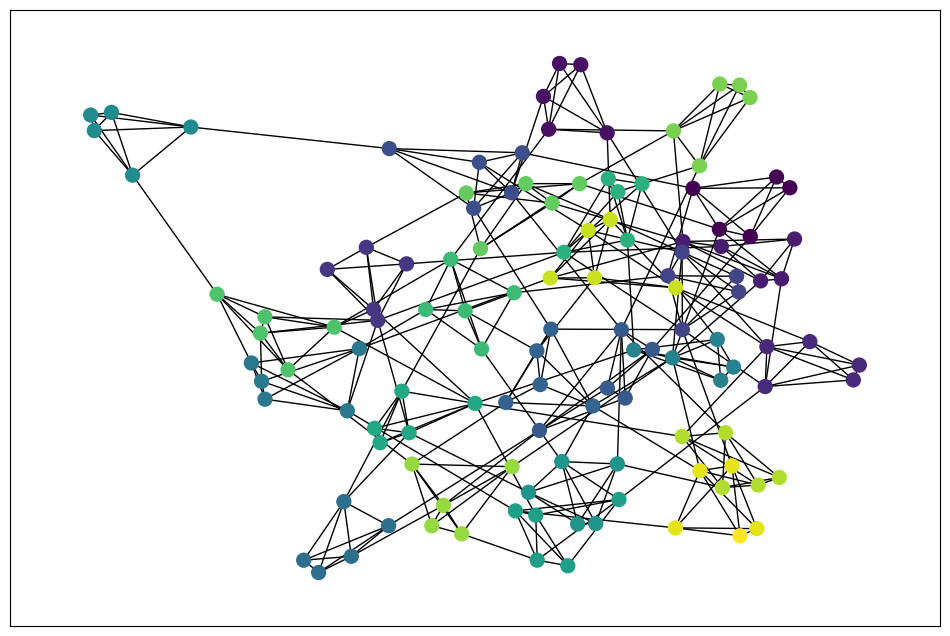

In [94]:
plot_graph(D1UNC_adj, D1UNC_labels)

In [95]:
D1UNC_labels = detect_communities(D1UNC_adj, 25)

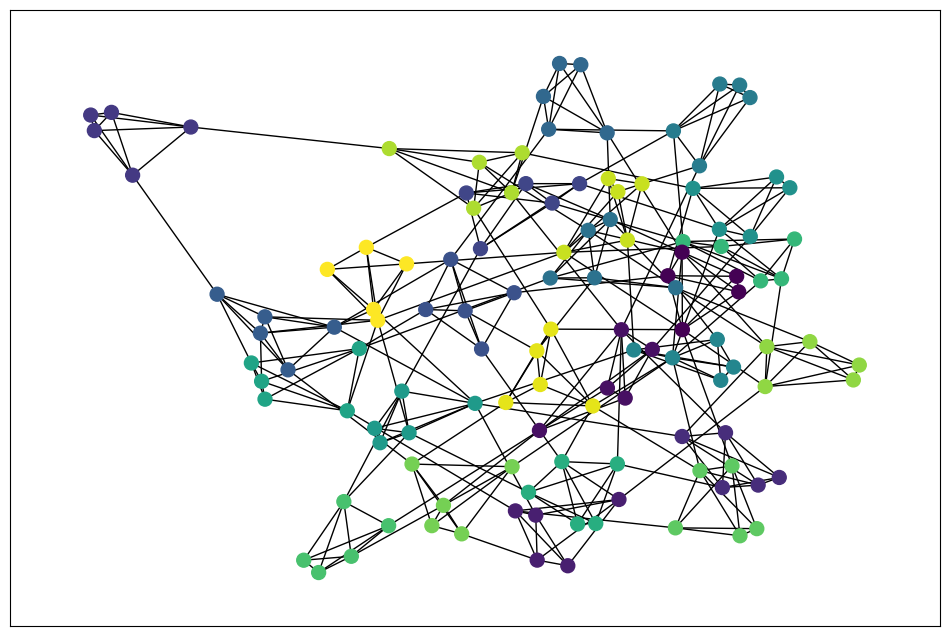

In [96]:
plot_graph(D1UNC_adj, D1UNC_labels)

In [97]:
D1UNC_adj = generate_adjacency(D1UNC)
D1UNC_labels = detect_communities(D1UNC_adj, K)
D1UNC_results["laplace"] = D1UNC_labels + 1

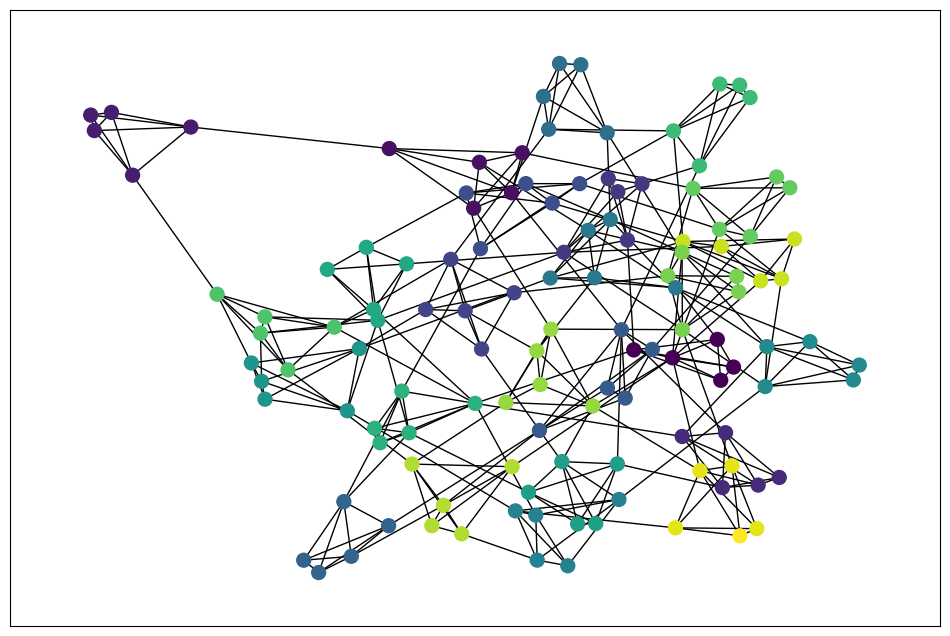

In [98]:
plot_graph(D1UNC_adj, D1UNC_labels)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124], [55, 56, 57, 58, 59])
([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 60, 61, 62, 63, 64, 80, 81, 82, 83, 84, 95, 96, 97, 98, 99, 105, 106, 107, 108, 109, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124], [55, 56, 57, 58, 59], [65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 100, 101,

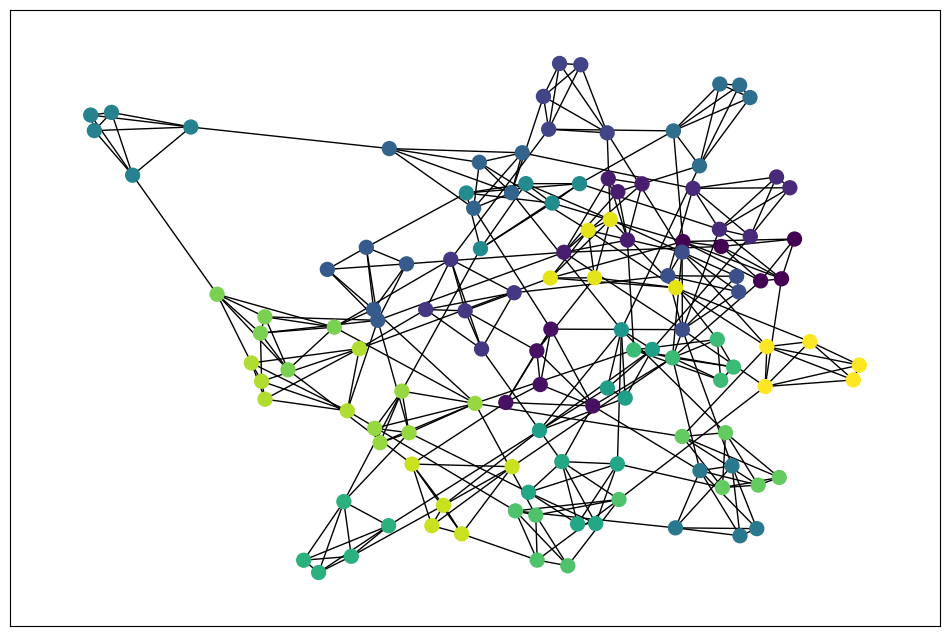

In [99]:
G = nx.convert_matrix.from_numpy_array(generate_adjacency(D1UNC))
communities_generator = community.girvan_newman(G)
for communities in itertools.islice(communities_generator, K-1):
    grouped_labels = tuple(sorted(c) for c in communities)
    print(grouped_labels)

D1UNC_labels = np.zeros(len(G))
for k, com in enumerate(grouped_labels):
    for idx in com:
        D1UNC_labels[idx] = k + 1
D1UNC_results["girvan_newman"] = np.array([int(i) for i in D1UNC_labels])
plot_graph(D1UNC_adj, D1UNC_labels)

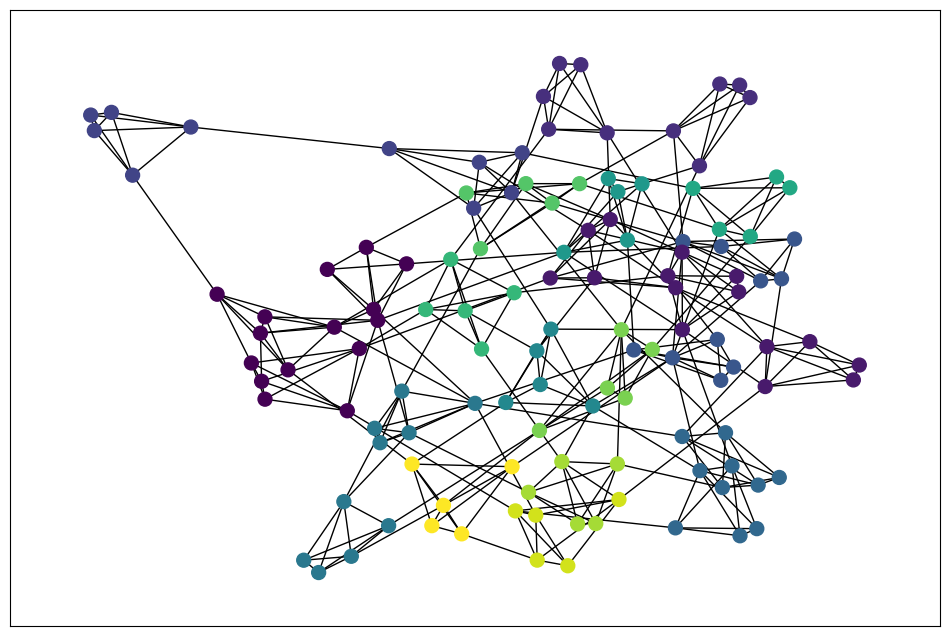

In [100]:
c = greedy_modularity_communities(G)
grouped_labels = [sorted(c[k]) for k in range(len(c))]

D1UNC_labels = np.zeros(len(G))
for k, com in enumerate(grouped_labels):
    for idx in com:
        D1UNC_labels[idx] = k + 1
D1UNC_results["greedy_modularity_communitites"] = np.array([int(i) for i in D1UNC_labels])
plot_graph(D1UNC_adj, D1UNC_labels)

In [101]:
len(grouped_labels)

16

In [109]:
%%timeit
grouped_labels = community.louvain_communities(G, seed=123)
D1UNC_labels = np.zeros(len(G))
for k, com in enumerate(grouped_labels):
    for idx in com:
        D1UNC_labels[idx] = k + 1

3.6 ms ± 56.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


16

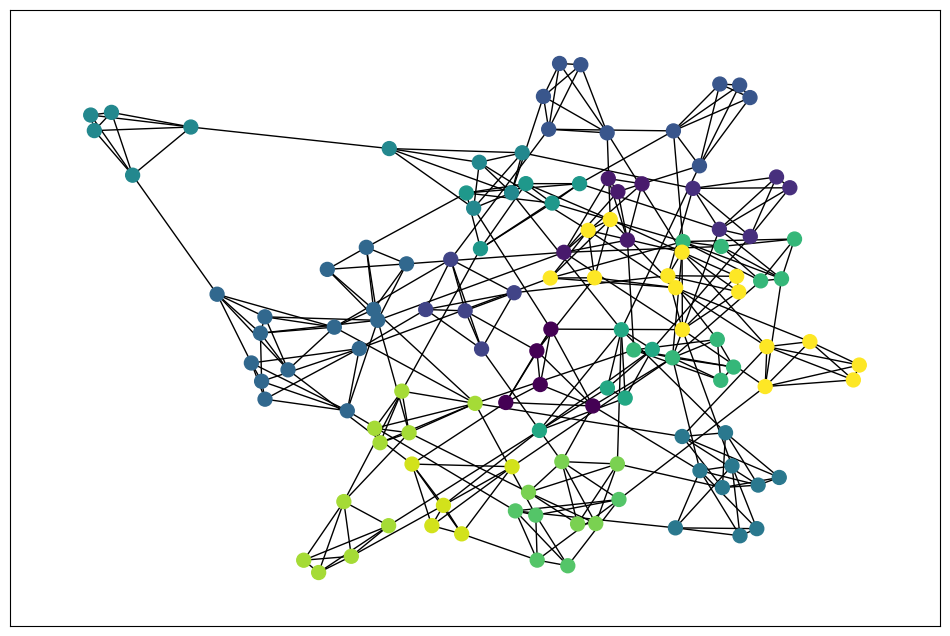

In [110]:
D1UNC_results["louvain_communities"] = np.array([int(i) for i in D1UNC_labels])
plot_graph(D1UNC_adj, D1UNC_labels)

len(grouped_labels)

In [104]:
D1UNC_df = pd.DataFrame({"x": range(1, len(G) + 1), "y": D1UNC_results["louvain_communities"]})
D1UNC_df.head()
D1UNC_df.to_csv("results/D1-UNC.csv", header=False, index=False)

### <span style='font-family:Georgia'> D2-K=7

In [105]:
D2K7_results = {}

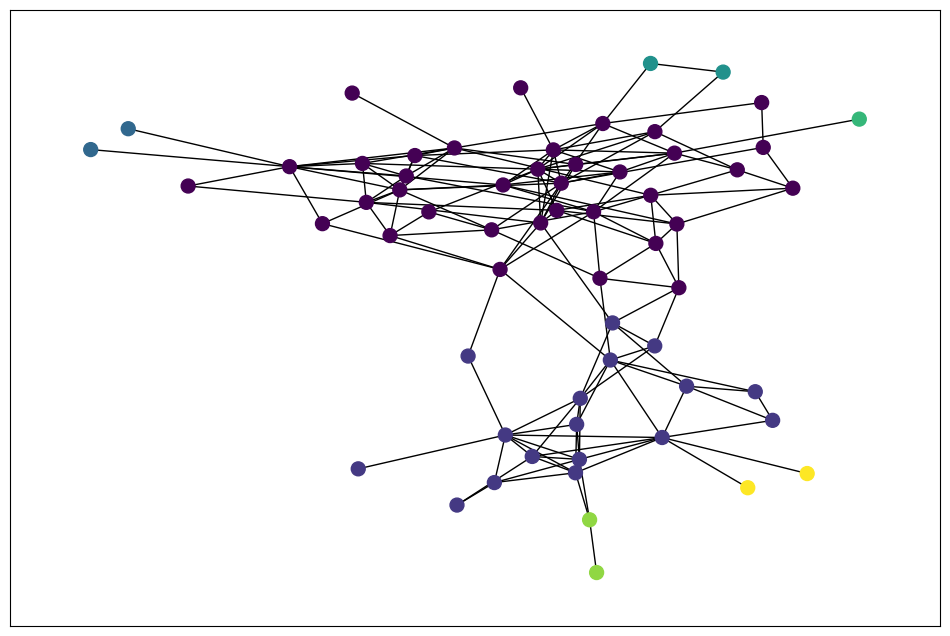

In [106]:
D2K7_adj = generate_adjacency(D2K7)
D2K7_labels = detect_communities(D2K7_adj, 7)
plot_graph(D2K7_adj, D2K7_labels)

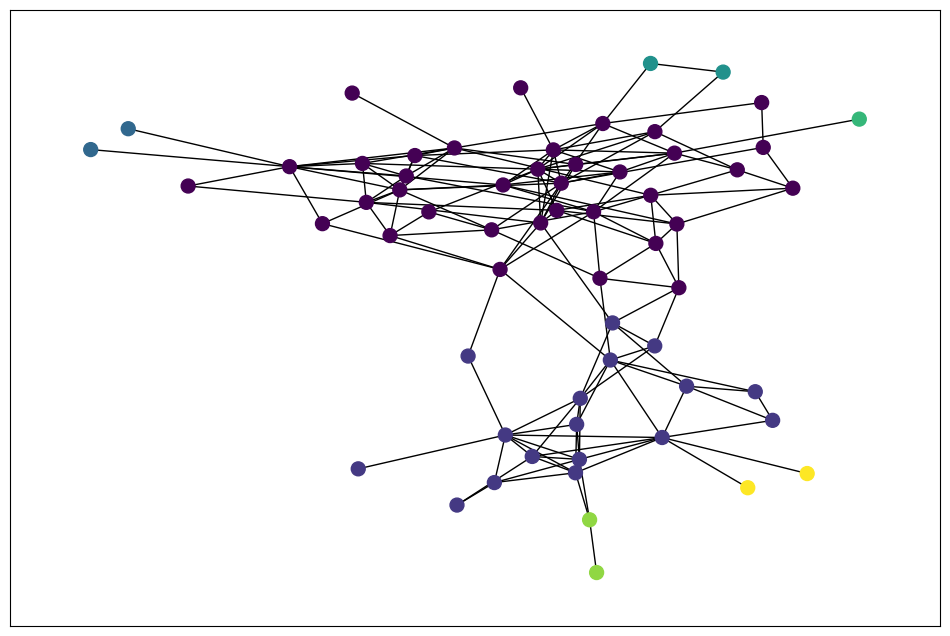

In [111]:
D2K7_results["laplace"] = D2K7_labels + 1
plot_graph(D2K7_adj, D2K7_labels)

([0, 2, 3, 4, 8, 10, 11, 12, 14, 15, 16, 18, 20, 21, 23, 24, 28, 29, 30, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 55, 58, 59, 61], [1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 39, 41, 48, 54, 56, 57, 60])
([0, 2, 3, 4, 8, 10, 11, 12, 14, 15, 16, 18, 20, 21, 23, 24, 28, 29, 30, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 55, 58, 59], [1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 39, 41, 48, 54, 56, 57, 60], [53, 61])
([0, 2, 10, 28, 30, 42, 47], [1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 39, 41, 48, 54, 56, 57, 60], [3, 4, 8, 11, 12, 14, 15, 16, 18, 20, 21, 23, 24, 29, 33, 34, 35, 36, 37, 38, 40, 43, 44, 45, 46, 49, 50, 51, 52, 55, 58, 59], [53, 61])
([0, 2, 10, 28, 30, 42, 47], [1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 39, 41, 48, 54, 56, 57, 60], [3, 8, 12, 14, 16, 20, 33, 34, 36, 37, 38, 40, 43, 44, 46, 49, 50, 52, 58, 59], [4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55], [53, 61])
([0, 2, 10, 28, 

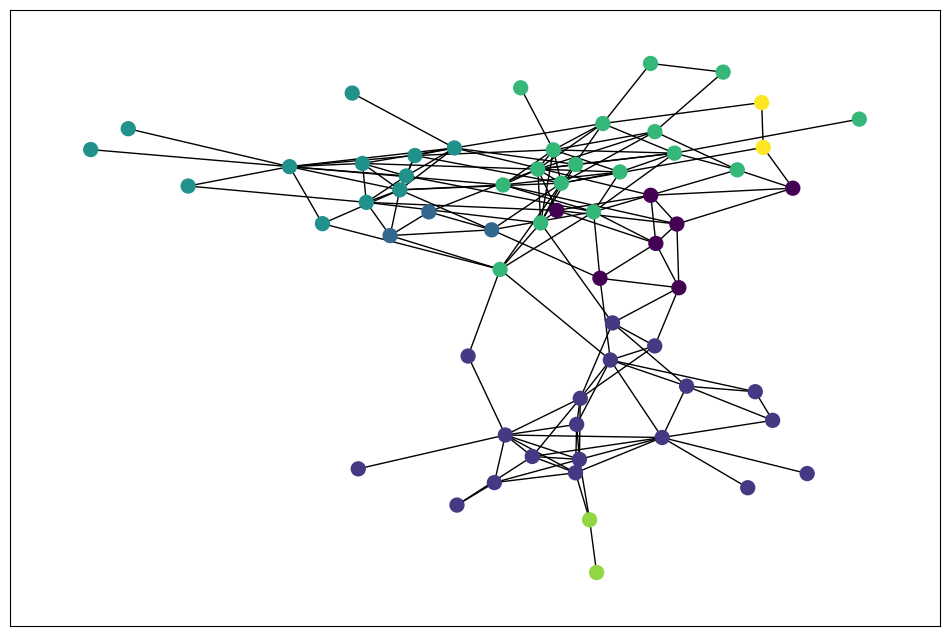

In [112]:
K = 7
G = nx.convert_matrix.from_numpy_array(generate_adjacency(D2K7))
communities_generator = community.girvan_newman(G)
for communities in itertools.islice(communities_generator, K-1):
    grouped_labels = tuple(sorted(c) for c in communities)
    print(grouped_labels)

D2K7_labels = np.zeros(len(G))
for k, com in enumerate(grouped_labels):
    for idx in com:
        D2K7_labels[idx] = k + 1
D2K7_results["girvan_newman"] = np.array([int(i) for i in D2K7_labels])
plot_graph(D2K7_adj, D2K7_labels)

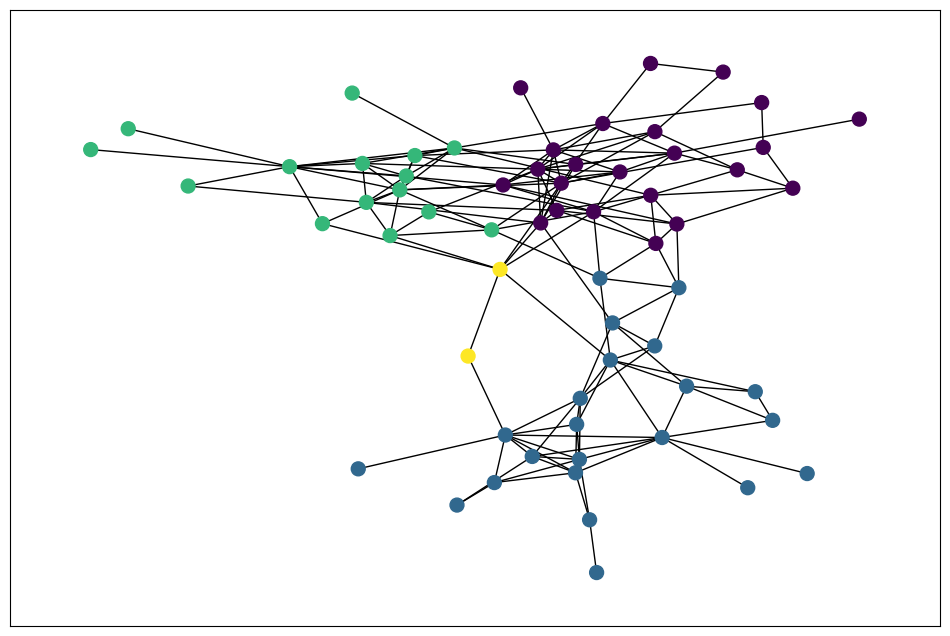

In [113]:
c = greedy_modularity_communities(G, best_n=K)
grouped_labels = [sorted(c[k]) for k in range(len(c))]

D2K7_labels = np.zeros(len(G))
for k, com in enumerate(grouped_labels):
    for idx in com:
        D2K7_labels[idx] = k + 1
D2K7_results["greedy_modularity_communitites"] = np.array([int(i) for i in D2K7_labels])
plot_graph(D2K7_adj, D2K7_labels)

In [119]:
%%timeit
communities = community.asyn_fluidc(G, K)
grouped_labels = []
for k in range(K):
    com = sorted(next(communities))
    grouped_labels.append(com)
    print(com)

[0, 2, 10, 42, 47, 53, 61]
[1, 7, 8, 19, 20, 25, 26, 27, 28, 30]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 54, 56, 57, 60]
[23, 34, 36, 39, 44, 49, 59]
[3, 14, 38, 40, 52, 58]
[12, 16, 33, 37, 43, 46, 50]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[2, 34, 44, 53, 61]
[3, 8, 12, 14, 16, 20, 33, 36, 37, 40, 50, 59]
[0, 10, 28, 30, 42, 47]
[38, 43, 46, 49, 52, 58]
[5, 6, 9, 13, 17, 22, 31, 32, 39, 41, 48, 56, 57, 60]
[1, 7, 19, 25, 26, 27, 54]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[1, 17, 22, 25, 26, 27, 31]
[12, 14, 16, 33, 34, 37, 38, 43, 46, 49, 53, 58, 61]
[4, 11, 18, 21, 24, 29, 35, 45, 50, 51]
[0, 3, 8, 15, 40, 52, 55, 59]
[20, 23, 36, 39, 44]
[2, 7, 10, 19, 28, 30, 42, 47]
[3, 8, 20, 28, 30, 47, 59]
[1, 5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[12, 14, 16, 33, 34, 37, 38, 43, 50, 58]
[0, 2, 10, 42, 44, 61]
[4, 23, 36, 39, 55]
[11, 15, 18, 21, 24, 29, 35, 45, 51, 52]
[7, 19, 40, 46, 49, 53]
[10, 29, 35, 52]
[1,

[1, 17, 22, 25, 26, 27, 31]
[0, 2, 7, 10, 19, 30, 42, 47]
[12, 14, 16, 33, 34, 37, 40, 50, 52, 61]
[4, 11, 15, 18, 21, 23, 24, 29, 45, 51, 55]
[3, 8, 20, 28, 36, 59]
[35, 38, 43, 44, 46, 49, 53, 58]
[5, 6, 9, 13, 32, 39, 41, 48, 54, 56, 57, 60]
[1, 7, 19, 25, 26, 27, 28, 30, 36, 39, 47]
[0, 14, 34, 37, 40, 43, 46, 49, 52, 53, 61]
[32, 60]
[5, 6, 9, 13, 17, 22, 31, 41, 48, 54, 56, 57]
[3, 8, 15, 18, 21, 24, 29, 35, 45, 59]
[2, 10, 12, 16, 20, 33, 38, 42, 44, 50, 58]
[4, 11, 23, 51, 55]
[0, 7, 10, 19, 28, 30, 42, 47]
[5, 6, 9, 13, 32, 39, 41, 48, 54, 56, 57, 60]
[14, 16, 20, 33, 34, 37, 38, 40, 44, 50, 52, 58]
[3, 8, 15, 18, 23, 24, 36, 45, 59]
[1, 17, 22, 25, 26, 27, 31]
[2, 29, 35, 43, 46, 53, 61]
[4, 11, 12, 21, 49, 51, 55]
[1, 25, 26, 27]
[4, 11, 15, 18, 21, 24, 29, 35, 40, 45, 51, 52, 55]
[5, 6, 9, 13, 32, 56, 60]
[23, 36, 39, 41, 48, 57, 59]
[0, 2, 7, 10, 19, 28, 30, 42, 47, 54]
[17, 22, 31]
[3, 8, 12, 14, 16, 20, 33, 34, 37, 38, 43, 44, 46, 49, 50, 53, 58, 61]
[1, 7, 17, 19, 22, 2

[3, 8, 12, 14, 16, 33, 34, 37, 61]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[0, 2, 10, 28, 30, 42, 47]
[4, 11, 50, 51, 55]
[15, 18, 21, 24, 29, 35, 45]
[20, 38, 43, 44, 46, 49, 53, 58]
[23, 36, 39, 40, 52, 59]
[5, 9, 13, 32, 39, 41, 48, 57, 60]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[3, 8, 20, 28, 36, 37, 43, 46, 59]
[12, 14, 16, 33, 34, 38, 40, 44, 49, 50, 52, 58]
[1, 7, 19, 25, 26, 27, 54]
[6, 17, 22, 31, 56]
[0, 2, 10, 30, 42, 47, 53, 61]
[0, 2, 10, 42, 44, 47, 53, 61]
[15, 18, 21, 23, 24, 29, 35, 36, 45, 51, 55, 59]
[17, 22, 25, 26, 27, 31]
[12, 14, 16, 33, 34, 37, 38, 40, 43, 46, 49, 52, 58]
[1, 6, 7, 19, 30, 41, 54, 56]
[5, 9, 13, 32, 39, 48, 57, 60]
[3, 4, 8, 11, 20, 28, 50]
[5, 6, 9, 13, 17, 22, 41, 48, 56, 57]
[32, 60]
[0, 10, 12, 14, 16, 33, 34, 37, 40, 42, 47, 49, 50, 52]
[4, 11, 23, 51, 55]
[2, 20, 36, 38, 39, 43, 44, 46, 53, 58, 61]
[1, 7, 19, 25, 26, 27, 28, 30, 31, 54]
[3, 8, 15, 18, 21, 24, 29, 35, 45, 59]
[3, 4, 8, 11, 15, 18

[1, 17, 22, 25, 26, 27, 31]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[12, 14, 16, 33, 37, 38, 40, 43, 50, 52, 53, 58, 61]
[34, 46, 49]
[2, 3, 8, 20, 36, 39, 44, 59]
[0, 7, 10, 19, 28, 30, 42, 47]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[20, 28, 30, 38, 44, 47, 52, 58]
[34, 46, 49]
[0, 2, 10, 15, 40, 42, 55]
[4, 11, 18, 21, 24, 29, 35, 45, 51]
[12, 14, 16, 33, 37, 43, 50, 53, 61]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[3, 8, 23, 36, 39, 59]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[5, 6, 9, 13, 32, 41, 54, 57, 60]
[7, 25, 26, 27]
[1, 17, 19, 22, 31]
[0, 2, 3, 8, 10, 20, 28, 30, 42, 44, 47, 59]
[36, 39, 48, 56]
[12, 14, 16, 33, 34, 37, 38, 40, 43, 46, 49, 50, 52, 53, 58, 61]
[43, 46, 49, 53, 61]
[5, 6, 9, 13, 17, 22, 31, 32, 56, 60]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[0, 2, 3, 8, 10, 20, 28, 30, 42, 47, 50, 59]
[12, 14, 16, 33, 34, 36, 37, 38, 40, 44, 52, 58]
[39, 41, 48, 57]
[1, 7, 19, 25, 26, 27, 54]
[5, 6, 9, 13, 32, 39

[17, 22, 25, 31]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[3, 8, 14, 23, 36, 37, 40, 52, 59]
[2, 16, 20, 38, 43, 44, 46, 53, 58, 61]
[0, 10, 12, 28, 30, 33, 34, 42, 47, 49, 50]
[5, 6, 9, 13, 32, 41, 56, 57, 60]
[1, 7, 19, 26, 27, 39, 48, 54]
[3, 8, 12, 14, 16, 20, 33, 34, 37, 38, 43, 44, 46, 49, 50, 58]
[0, 2, 10, 28, 30, 42, 47, 53, 61]
[15, 36, 40, 52, 55, 59]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 51]
[7, 19, 39, 41, 48, 54, 57]
[5, 6, 9, 13, 32, 56, 60]
[1, 17, 22, 25, 26, 27, 31]
[0, 3, 15, 36, 39, 40, 52, 59]
[8, 18, 21, 24, 29, 35, 45]
[2, 7, 10, 19, 28, 30, 42, 47]
[1, 5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[12, 14, 33, 34, 37, 49, 61]
[4, 11, 23, 51, 55]
[16, 20, 38, 43, 44, 46, 50, 53, 58]
[0, 3, 8, 15, 40, 55, 59]
[5, 9, 13, 17, 22, 31, 32, 41, 48, 57, 60]
[2, 10, 25, 26, 27, 42, 47]
[4, 11, 18, 21, 24, 29, 35, 45, 51]
[1, 20, 23, 28, 36, 39, 44]
[6, 7, 19, 30, 54, 56]
[12, 14, 16, 33, 34, 37, 38, 43, 46, 49, 50, 52, 53, 58, 61]
[5, 6, 9, 13, 32, 41

[1, 7, 19, 28, 30, 54]
[3, 4, 8, 11, 18, 21, 24, 29, 35, 45, 51, 52, 59]
[0, 2, 10, 15, 40, 42, 47, 55]
[17, 22, 25, 26, 27, 31]
[5, 6, 9, 13, 41, 48, 56, 57]
[12, 14, 16, 20, 33, 34, 37, 38, 43, 44, 46, 49, 50, 53, 58, 61]
[23, 32, 36, 39, 60]
[1, 7, 19, 25, 26, 27, 30]
[4, 11, 12, 14, 16, 23, 33, 34, 46, 49, 50, 51, 55]
[15, 18, 21, 24, 29, 35, 38, 43, 45, 52, 58]
[5, 6, 9, 13, 32, 41, 54, 56, 57, 60]
[0, 2, 10, 42, 44, 47, 53, 61]
[3, 8, 20, 28, 36, 37, 40, 59]
[17, 22, 31, 39, 48]
[3, 12, 14, 16, 33, 34, 37, 38, 40, 50, 52, 58]
[1, 7, 19, 23, 26, 27, 36, 39, 59]
[43, 46, 49, 53, 61]
[0, 2, 8, 10, 20, 28, 30, 42, 44, 47]
[6, 17, 22, 25, 31, 56]
[5, 9, 13, 32, 41, 48, 54, 57, 60]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[12, 14, 16, 20, 33, 34, 38, 44, 50, 52, 58]
[5, 6, 9, 13, 32, 48, 56, 57, 60]
[17, 22, 25, 26, 27, 31]
[0, 2, 10, 15, 28, 30, 40, 42, 47, 55]
[3, 8, 23, 36, 37, 39, 45, 59]
[4, 11, 18, 21, 24, 29, 35, 43, 46, 49, 51, 53, 61]
[1, 7, 19, 41, 54]
[0, 7, 15, 19, 30, 3

[12, 14, 16, 33, 34, 37, 38, 40, 44, 50, 52, 58]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[1, 17, 22, 25, 26, 27, 31]
[2, 43, 46, 49, 53, 61]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[3, 8, 20, 23, 28, 36, 39, 59]
[0, 7, 10, 19, 30, 42, 47]
[1, 7, 19, 25, 26, 27, 54]
[8, 20, 28, 30, 44, 47]
[12, 14, 16, 33, 34, 37, 38, 40, 43, 46, 49, 52, 58]
[0, 2, 10, 42, 50, 53, 61]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[3, 23, 36, 39, 59]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[12, 16, 20, 33, 34, 38, 44, 49, 50, 58]
[1, 7, 19, 25, 26, 27, 28, 30]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[39, 41, 48, 54, 57]
[0, 2, 10, 42, 47, 53, 61]
[3, 8, 14, 36, 37, 40, 43, 46, 52, 59]
[5, 6, 9, 13, 17, 22, 31, 32, 56, 60]
[1, 17, 22, 25, 26, 27, 31]
[2, 3, 8, 34, 36, 37, 44, 49, 53, 59, 61]
[5, 6, 9, 13, 32, 56, 60]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[39, 41, 48, 54, 57]
[12, 14, 16, 20, 33, 38, 40, 43, 46, 50, 52, 58]
[0, 7, 10, 19, 28, 30, 42, 47]
[0, 2, 10, 28, 30, 4

[12, 14, 16, 20, 33, 34, 38, 40, 44, 50, 52, 58]
[3, 8, 15, 18, 21, 24, 37, 45, 59]
[4, 11, 23, 51, 55]
[1, 13, 28, 32, 36, 41, 54, 60]
[0, 7, 19, 25, 26, 27, 30, 42, 47]
[5, 6, 9, 17, 22, 31, 39, 48, 56, 57]
[2, 10, 29, 35, 43, 46, 49, 53, 61]
[5, 6, 9, 13, 32, 41, 48, 56, 57, 60]
[15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[20, 36, 38, 39, 40, 44, 52, 58]
[12, 14, 16, 33, 34, 37, 43, 46, 49, 50]
[0, 2, 10, 28, 30, 42, 47, 53, 61]
[1, 7, 17, 19, 22, 25, 26, 27, 31, 54]
[3, 4, 8, 11, 59]
[17, 22, 25, 26, 27, 31]
[3, 8, 12, 14, 16, 20, 33, 34, 36, 37, 40, 50]
[5, 6, 9, 13, 32, 39, 48, 56, 57, 60]
[35, 38, 43, 46, 49, 52, 53, 58]
[0, 2, 10, 42, 44, 47, 61]
[1, 7, 19, 28, 30, 41, 54]
[4, 11, 15, 18, 21, 23, 24, 29, 45, 51, 55, 59]
[0, 7, 10, 19, 20, 28, 30, 42, 47]
[2, 34, 44, 49, 53, 61]
[5, 6, 9, 13, 32, 39, 41, 48, 54, 56, 57, 60]
[3, 8, 15, 36, 55, 59]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 51]
[1, 17, 22, 25, 26, 27, 31]
[12, 14, 16, 33, 37, 38, 40, 43, 46, 50, 52, 58]
[0, 3, 8, 15, 36, 40

[39, 41, 48, 54, 57]
[17, 22, 31, 32, 60]
[3, 4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 52, 55, 59]
[12, 14, 16, 33, 34, 37, 38, 43, 44, 46, 49, 50, 53, 58, 61]
[1, 8, 20, 25, 26, 27, 28, 36]
[5, 6, 9, 13, 56]
[0, 2, 7, 10, 19, 30, 40, 42, 47]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[12, 14, 16, 20, 33, 38, 40, 50, 52, 58]
[34, 44, 46, 49]
[2, 37, 43, 53, 61]
[3, 8, 15, 23, 36, 39, 45, 59]
[4, 11, 18, 21, 24, 29, 51, 55]
[0, 10, 28, 30, 35, 42, 47]
[7, 19, 30, 32, 54, 60]
[12, 14, 16, 33, 34, 37, 38, 43, 46, 49, 53, 58, 61]
[1, 17, 22, 25, 26, 27, 31]
[5, 6, 9, 13, 41, 48, 56, 57]
[3, 4, 11, 23, 36, 39, 51, 55, 59]
[0, 2, 8, 10, 20, 28, 42, 44, 47, 50]
[15, 18, 21, 24, 29, 35, 40, 45, 52]
[12, 14, 33, 34, 36, 37, 39, 40, 43, 46, 49, 52]
[2, 10, 29, 35, 53, 61]
[0, 7, 19, 25, 26, 27, 30, 42, 47]
[4, 11, 15, 18, 21, 23, 24, 45, 50, 51, 55]
[5, 6, 9, 13, 41, 48, 54, 56, 57]
[3, 8, 16, 20, 28, 38, 44, 58, 59]
[1, 17, 22, 31, 32, 60]
[1, 25, 26, 27]
[0, 

[0, 7, 10, 19, 30, 42, 47, 54]
[5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 56, 57, 60]
[17, 22, 31]
[0, 14, 16, 33, 34, 37, 40, 50, 52, 61]
[3, 4, 8, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55, 59]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[2, 7, 10, 19, 20, 28, 30, 42, 44, 47]
[12, 38, 43, 46, 49, 53, 58]
[1, 23, 25, 26, 27, 36, 39]
[17, 22, 25, 26, 27, 31]
[5, 6, 9, 13, 41, 56, 57]
[1, 7, 19, 28, 30, 47, 54]
[3, 8, 12, 14, 16, 20, 33, 34, 37, 38, 43, 44, 46, 49, 50, 58]
[0, 2, 10, 29, 35, 42, 52, 53, 61]
[4, 11, 15, 18, 21, 23, 24, 36, 40, 45, 51, 55, 59]
[32, 39, 48, 60]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[12, 14, 16, 20, 33, 38, 44, 50, 58]
[34, 37, 43, 46, 49, 53, 61]
[3, 4, 8, 11, 23, 45, 51, 59]
[0, 2, 10, 15, 28, 30, 42, 47, 55]
[18, 21, 24, 29, 35, 36, 39, 40, 52]
[1, 7, 17, 19, 22, 25, 26, 27, 31]
[0, 2, 10, 12, 16, 20, 33, 34, 42, 44, 47, 49, 50, 61]
[4, 11, 15, 18, 21, 23, 24, 36, 37, 39, 40, 45, 51, 55]
[32, 60]
[5, 6, 9, 13, 41, 48, 54, 56, 57]
[1, 17, 22, 25, 26

[5, 6, 9, 13, 32, 39, 48, 56, 57, 60]
[1, 7, 19, 36, 40, 41, 54]
[17, 22, 25, 26, 27, 31]
[0, 2, 8, 10, 20, 28, 30, 42, 47]
[12, 34, 38, 44, 49, 52, 58]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55, 59]
[3, 14, 16, 33, 37, 43, 46, 50, 53, 61]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[11, 23, 51, 55]
[38, 43, 44, 46, 49, 52, 53, 58, 61]
[0, 2, 8, 10, 20, 28, 30, 42, 47]
[4]
[12, 14, 16, 33, 34, 36, 37, 39, 40, 50]
[3, 15, 18, 21, 24, 29, 35, 45, 59]
[3, 8, 12, 14, 16, 20, 33, 34, 37, 38, 43, 44, 46, 49, 50, 52, 58, 59]
[6, 9, 13, 39, 41, 48, 54, 57]
[5, 56]
[1, 17, 22, 25, 26, 27, 31]
[32, 60]
[0, 2, 7, 10, 19, 23, 28, 30, 36, 40, 42, 47]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 53, 55, 61]
[4, 11, 15, 18, 21, 23, 24, 45, 51, 55]
[3, 34, 44, 49]
[1, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 54, 60]
[0, 2, 10, 28, 30, 42, 47, 61]
[5, 8, 36, 39, 48, 56, 57, 59]
[12, 14, 16, 20, 33, 37, 38, 40, 50, 58]
[29, 35, 43, 46, 52, 53]
[5, 9, 13, 32, 41, 4

[4, 11, 15, 18, 21, 23, 24, 45, 51, 55]
[29, 35, 43, 46, 49, 52, 53]
[3, 8, 12, 14, 16, 20, 33, 34, 36, 37, 38, 40, 44, 58, 59]
[5, 6, 9, 13, 32, 39, 41, 48, 56, 57, 60]
[17, 22, 25, 31]
[1, 7, 19, 26, 27, 28, 30, 54]
[0, 2, 10, 42, 47, 50, 61]
[4, 11, 15, 18, 21, 23, 24, 29, 45, 51, 55, 59]
[1, 7, 19, 25, 26, 27, 30, 54]
[0, 2, 8, 10, 12, 20, 28, 42, 47, 50]
[5, 6, 9, 13, 17, 22, 31, 32, 56, 60]
[36, 39, 41, 48, 57]
[3, 14, 16, 33, 34, 37, 38, 40, 44, 52, 58]
[35, 43, 46, 49, 53, 61]
[2, 53, 61]
[1, 7, 19, 25, 26, 27, 36, 39, 54]
[12, 14, 16, 33, 34, 37, 40, 43, 46, 49, 52]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 50, 51]
[3, 8, 20, 28, 38, 44, 58, 59]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[0, 10, 15, 30, 42, 47, 55]
[0, 14, 15, 34, 40, 49, 52]
[12, 16, 20, 33, 38, 44, 50, 58]
[1, 7, 19, 25, 26, 27, 28, 30, 54]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[2, 10, 42, 43, 46, 47, 53, 61]
[4, 11, 18, 21, 24, 29, 35, 51, 55]
[3, 8, 23, 36, 37, 39, 45, 59]
[1, 25, 26, 27, 36, 

[23, 36, 37, 39, 40, 61]
[1, 7, 19, 25, 26, 27, 41, 54]
[12, 14, 16, 33, 34, 38, 43, 46, 49, 52, 53, 58]
[4, 11, 51, 55]
[2, 3, 8, 20, 28, 30, 42, 44, 47, 50]
[5, 6, 9, 13, 17, 22, 31, 32, 48, 56, 57, 60]
[0, 10, 15, 18, 21, 24, 29, 35, 45, 59]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[1, 17, 22, 25, 26, 27, 31]
[12, 14, 16, 33, 38, 43, 46, 50, 52, 58]
[6, 7, 19, 39, 48, 54, 57]
[5, 9, 13, 32, 41, 56, 60]
[3, 8, 20, 36, 37, 40, 53, 59, 61]
[0, 2, 10, 28, 30, 34, 42, 44, 47, 49]
[3, 8, 12, 21, 33, 37, 43, 53, 61]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[4, 11, 15, 18, 23, 24, 45, 51, 55, 59]
[0, 2, 10, 29, 35, 42, 47, 52]
[7, 19, 28, 30, 36, 39, 40]
[14, 16, 20, 34, 38, 44, 46, 49, 50, 58]
[1, 17, 22, 25, 26, 27, 31]
[1, 17, 25, 26, 27, 28]
[5, 6, 9, 13, 41, 54, 56, 57]
[12, 14, 16, 20, 33, 34, 38, 43, 44, 50, 52, 58]
[3, 8, 23, 36, 37, 39, 45, 59]
[0, 2, 7, 10, 19, 30, 40, 42, 47]
[4, 11, 15, 18, 21, 24, 29, 35, 46, 49, 51, 53, 55, 61]
[22, 31, 32, 48, 60]
[3, 8, 12, 14, 33, 3

[1, 7, 17, 19, 22, 25, 26, 27, 31]
[0, 2, 10, 30, 42, 47, 53, 61]
[4, 11, 23, 36, 50, 51, 55]
[8, 15, 18, 20, 21, 24, 28, 29, 35, 45, 59]
[5, 6, 9, 13, 32, 39, 41, 48, 54, 56, 57, 60]
[3, 14, 16, 38, 40, 52, 58]
[12, 33, 34, 37, 43, 44, 46, 49]
[5, 6, 9, 13, 32, 41, 54, 56, 57, 60]
[1, 17, 22, 25, 26, 27, 31, 48]
[12, 33, 34, 37, 40, 43, 46, 49, 53, 61]
[0, 2, 7, 10, 19, 30, 42, 47]
[14, 16, 38, 44, 50, 52, 58]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[3, 8, 20, 28, 36, 39, 59]
[7, 8, 19, 20, 28, 30, 47]
[2, 10, 42, 53, 61]
[0, 3, 15, 36, 39, 40, 59]
[1, 5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[34, 44, 46, 49]
[12, 14, 16, 33, 37, 38, 43, 50, 52, 58]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[16, 20, 23, 36, 38, 39, 44, 50]
[5, 6, 7, 9, 13, 19, 32, 41, 48, 54, 56, 57, 60]
[3, 8, 12, 14, 33, 34, 37, 40, 52]
[1, 17, 22, 25, 26, 27, 31]
[0, 2, 10, 28, 30, 42, 47]
[43, 46, 49, 53, 58, 61]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55, 59]
[34, 44, 46, 49]
[0,

[3, 8, 15, 18, 21, 23, 24, 29, 45, 59]
[5, 6, 9, 13, 41, 48, 54, 56, 57]
[20, 34, 36, 39, 44, 46, 49]
[0, 2, 7, 10, 19, 28, 30, 35, 42, 47]
[4, 11, 50, 51, 55]
[12, 14, 16, 33, 37, 38, 40, 43, 52, 53, 58, 61]
[1, 17, 22, 25, 26, 27, 31, 32, 60]
[32, 60]
[0, 2, 7, 10, 15, 19, 28, 30, 40, 42, 47]
[5, 6, 9, 13, 39, 41, 48, 54, 56, 57]
[1, 17, 22, 25, 26, 27, 31]
[4, 11, 23, 51, 55]
[8, 12, 16, 18, 20, 21, 24, 29, 33, 35, 36, 37, 45, 50, 59]
[3, 14, 34, 38, 43, 44, 46, 49, 52, 53, 58, 61]
[0, 7, 15, 18, 24, 40, 55]
[4, 11, 23, 45, 50, 51]
[3, 21, 29, 35, 52, 59]
[12, 14, 16, 33, 34, 37, 43, 46, 49, 53, 61]
[2, 10, 38, 42, 44, 58]
[1, 5, 6, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[8, 20, 28, 30, 36, 39, 47]
[0, 10, 12, 14, 16, 33, 34, 37, 40, 42, 50]
[1, 7, 19, 28, 30, 41, 47, 54]
[5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 48, 56, 57, 60]
[20, 38, 44, 52, 58]
[3, 8, 36, 39, 59]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[2, 43, 46, 49, 53, 61]
[5, 6, 9, 13, 17, 22

[3, 8, 15, 18, 21, 24, 29, 35, 45, 59]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[4, 11, 23, 51, 55]
[0, 2, 10, 42, 47, 53, 61]
[1, 7, 19, 25, 26, 27, 28, 30, 54]
[16, 20, 36, 39, 44, 50]
[12, 14, 33, 34, 37, 38, 40, 43, 46, 49, 52, 58]
[1, 7, 17, 19, 22, 25, 26, 27, 28, 30, 31]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 51]
[0, 2, 10, 15, 42, 47, 55, 59]
[32, 60]
[3, 12, 14, 16, 33, 38, 40, 43, 50, 52, 58]
[5, 6, 9, 13, 41, 48, 54, 56, 57]
[8, 20, 34, 36, 37, 39, 44, 46, 49, 53, 61]
[1, 7, 19, 28, 30, 54]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55, 59]
[34, 44, 46, 49]
[17, 22, 25, 26, 27, 31]
[3, 8, 12, 14, 16, 20, 33, 36, 37, 38, 40, 43, 50, 52, 58]
[0, 2, 10, 42, 47, 53, 61]
[5, 6, 9, 13, 32, 39, 41, 48, 56, 57, 60]
[15, 18, 21, 24, 29, 35, 45, 52, 59]
[1, 7, 19, 25, 26, 27, 36, 54]
[4, 11, 23, 51, 55]
[5, 6, 9, 13, 17, 22, 31, 32, 39, 41, 48, 56, 57, 60]
[0, 2, 3, 8, 10, 28, 30, 42, 47]
[14, 33, 34, 37, 40, 43, 46, 49, 53, 61]
[12, 16, 20, 38, 44, 50, 58]
[12, 14, 16, 33, 37,

[14, 16, 20, 38, 44, 50, 52, 58]
[5, 6, 9, 13, 32, 41, 48, 56, 57, 60]
[12, 33, 34, 43, 46, 49, 53]
[0, 2, 10, 28, 30, 42, 47, 61]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[1, 7, 17, 19, 22, 25, 26, 27, 31, 54]
[3, 8, 23, 36, 37, 39, 40, 59]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[0, 2, 10, 42, 47, 53, 61]
[1, 7, 19, 25, 26, 27, 30, 54]
[16, 20, 23, 28, 36, 39, 50]
[14, 38, 43, 44, 46, 52, 58]
[12, 21, 33, 34, 37, 40, 49]
[3, 4, 8, 11, 15, 18, 24, 29, 35, 45, 51, 55, 59]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[1, 17, 22, 25, 26, 27, 31]
[3, 8, 20, 36, 39, 58, 59]
[2, 34, 44, 46, 49, 53, 61]
[12, 14, 16, 33, 37, 38, 40, 43, 50, 52]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[0, 7, 10, 19, 28, 30, 42, 47]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[14, 16, 33, 34, 36, 37, 39, 40, 50]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[3, 8, 20, 28, 38, 52, 58, 59]
[43, 46, 49, 53, 61]
[0, 2, 10, 30, 42, 44, 47]
[1, 7, 12, 19, 25, 26, 27, 54]
[5, 6, 9, 13, 39, 41

[3, 8, 15, 18, 24, 45, 59]
[38, 43, 44, 46, 49, 53, 58, 61]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[12, 14, 16, 23, 33, 34, 36, 37, 39, 40]
[0, 2, 10, 20, 28, 30, 42, 47, 50]
[1, 7, 17, 19, 22, 25, 26, 27, 31]
[4, 11, 21, 29, 35, 51, 52, 55]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[3, 8, 20, 36, 39, 59]
[12, 16, 33, 34, 37, 38, 44, 58, 61]
[0, 14, 40, 43, 46, 49, 52, 53]
[2, 7, 10, 19, 28, 30, 42, 47]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 50, 51, 55]
[1, 17, 22, 25, 26, 27, 31]
[0, 10, 28, 30, 42, 47]
[15, 18, 21, 24, 29, 35, 45, 55]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[4, 11, 23, 51]
[2, 34, 44, 46, 49, 53, 61]
[12, 14, 16, 20, 33, 38, 43, 50, 52, 58]
[3, 8, 36, 37, 39, 40, 59]
[5, 6, 7, 9, 13, 19, 32, 41, 48, 54, 56, 57, 60]
[1, 17, 22, 25, 26, 27, 31]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[23, 36, 37, 39, 40, 61]
[12, 14, 16, 20, 33, 38, 43, 50, 52, 53, 58]
[34, 44, 46, 49]
[0, 2, 3, 8, 10, 28, 30, 42, 47, 59]
[5, 9, 13, 39, 41, 4

[0, 7, 10, 19, 30, 42, 47]
[3, 8, 20, 28, 36, 59]
[2, 53, 61]
[1, 5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[34, 39, 44, 46, 49]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[12, 14, 16, 33, 37, 38, 40, 43, 50, 52, 58]
[1, 5, 6, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[12, 14, 16, 33, 38, 50, 58]
[4, 11, 23, 51, 55]
[7, 15, 18, 21, 24, 29, 35, 40, 45, 52]
[3, 8, 36, 39, 59]
[34, 37, 43, 46, 49, 53, 61]
[0, 2, 10, 20, 28, 30, 42, 44, 47]
[4, 11, 15, 18, 21, 23, 24, 45, 51, 55]
[0, 2, 7, 10, 19, 28, 30, 42, 47]
[20, 34, 38, 44, 49, 58]
[1, 17, 22, 25, 26, 27, 31]
[3, 8, 12, 14, 16, 33, 36, 37, 40, 50, 59, 61]
[5, 6, 9, 13, 32, 39, 41, 48, 54, 56, 57, 60]
[29, 35, 43, 46, 52, 53]
[8, 16, 20, 28, 38, 44, 50, 58]
[15, 18, 21, 24, 29, 35, 45, 51, 55, 59]
[3, 12, 14, 33, 34, 37, 43, 46, 49, 53, 61]
[0, 2, 4, 10, 11, 42, 47]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[1, 17, 22, 25, 26, 27, 31]
[7, 19, 23, 30, 36, 39, 40, 52]
[5, 6, 9, 13, 32, 39

[4, 11, 23, 36, 39, 51, 55]
[43, 46, 49, 53]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[3, 8, 15, 18, 21, 24, 29, 35, 45, 59]
[12, 14, 16, 33, 34, 37, 40, 50]
[0, 2, 10, 28, 30, 42, 47, 61]
[20, 38, 44, 52, 58]
[3, 8, 36, 37, 39, 53, 59, 61]
[0, 2, 10, 16, 20, 42, 44, 47, 50]
[1, 7, 19, 25, 26, 27, 28, 30]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[12, 14, 33, 34, 38, 40, 43, 46, 49, 52, 58]
[5, 6, 9, 13, 41, 48, 54, 56, 57]
[17, 22, 31, 32, 60]
[4, 11, 23, 51, 55]
[0, 2, 10, 28, 30, 42, 47]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[29, 35, 43, 52, 53]
[3, 8, 15, 18, 21, 24, 45, 59]
[12, 14, 16, 20, 33, 34, 38, 44, 50, 58]
[36, 37, 39, 40, 46, 49, 61]
[4, 11, 16, 23, 50, 51]
[1, 5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[2, 12, 33, 37, 43, 53, 61]
[34, 44, 46, 49]
[0, 7, 8, 10, 19, 20, 28, 30, 42, 47]
[3, 14, 36, 38, 39, 40, 52, 58, 59]
[15, 18, 21, 24, 29, 35, 45, 55]
[18, 21, 24, 29, 35,

[5, 6, 9, 13, 32, 41, 54, 56, 60]
[36, 39, 48, 57]
[3, 8, 15, 24, 29, 35, 52, 59]
[1, 17, 22, 25, 26, 27, 31]
[4, 11, 18, 21, 23, 45, 50, 51, 55]
[12, 14, 16, 20, 33, 34, 37, 38, 40, 43, 44, 46, 49, 53, 58]
[0, 2, 7, 10, 19, 28, 30, 42, 47, 61]
[3, 8, 16, 20, 28, 30, 36, 39, 47, 50, 59]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[0, 12, 14, 15, 24, 33, 40, 55]
[29, 35, 38, 43, 46, 52, 58]
[2, 10, 34, 42, 44, 49]
[4, 11, 18, 21, 23, 37, 45, 51, 53, 61]
[1, 7, 17, 19, 22, 25, 26, 27, 31]
[17, 22, 31]
[7, 25, 26, 27, 40, 52]
[5, 6, 9, 13, 41, 54, 56, 57]
[1, 3, 8, 19, 20, 23, 28, 30, 36, 39, 47, 59]
[2, 12, 14, 16, 33, 34, 37, 38, 43, 44, 46, 49, 53, 58, 61]
[0, 4, 10, 11, 15, 18, 21, 24, 29, 35, 42, 45, 50, 51, 55]
[32, 48, 60]
[1, 7, 19, 25, 26, 27, 28, 30, 54]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 51]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[3, 8, 15, 36, 39, 40, 55, 59]
[12, 14, 16, 33, 34, 37, 50, 61]
[0, 2, 10, 20, 38, 42, 44, 47, 52, 58]
[43, 46, 49, 53]
[12, 14, 16, 33, 34,

[1, 19, 20, 23, 28, 36, 41, 54]
[7, 25, 26, 27]
[5, 6, 9, 13, 17, 22, 31, 32, 39, 48, 56, 57, 60]
[14, 16, 33, 34, 37, 38, 43, 44, 46, 49, 50]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[0, 2, 10, 12, 30, 40, 42, 47, 52]
[3, 8, 53, 58, 59, 61]
[14, 16, 33, 37, 38, 40, 43, 52, 53, 58, 61]
[1, 7, 19, 26, 27, 36, 54, 59]
[2, 34, 44, 46, 49]
[6, 17, 22, 25, 31, 56]
[0, 3, 8, 10, 12, 20, 28, 30, 42, 47, 50]
[5, 9, 13, 32, 39, 41, 48, 57, 60]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[0, 2, 10, 42, 47, 61]
[1, 7, 19, 25, 26, 27, 28, 30, 54]
[20, 38, 43, 44, 46, 49, 53, 58]
[3, 8, 23, 36, 39, 59]
[12, 14, 16, 33, 34, 37, 40, 50, 52]
[5, 6, 9, 13, 32, 39, 41, 48, 56, 57, 60]
[4, 11, 16, 20, 23, 50, 51]
[12, 14, 33, 34, 38, 43, 44, 46, 49, 53, 58]
[0, 2, 10, 28, 30, 42, 47]
[3, 8, 21, 36, 37, 45, 59, 61]
[15, 18, 24, 29, 35, 40, 52, 55]
[1, 7, 17, 19, 22, 25, 26, 27, 31, 54]
[4, 11, 18, 21, 23, 

[5, 6, 9, 13, 32, 41, 56, 57, 60]
[17, 22, 25, 26, 27, 31]
[3, 8, 12, 14, 16, 20, 33, 37, 38, 43, 46, 50, 53, 58]
[4, 11, 15, 18, 21, 24, 29, 35, 40, 45, 51, 52, 55]
[1, 7, 19, 28, 30, 54]
[0, 2, 10, 34, 42, 44, 47, 49, 61]
[23, 36, 39, 48, 59]
[1, 17, 22, 25, 26, 27, 31]
[0, 2, 10, 28, 30, 42, 47]
[4, 11, 18, 21, 24, 29, 35, 51]
[7, 12, 14, 16, 19, 33, 37, 38, 40, 43, 52, 53, 58, 61]
[3, 8, 15, 23, 45, 50, 55, 59]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[20, 34, 36, 39, 44, 46, 49]
[4, 11, 51, 55]
[15, 18, 21, 24, 29, 35, 37, 40, 45, 52]
[12, 14, 16, 20, 33, 34, 38, 44, 49, 50]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[3, 8, 23, 36, 39, 59]
[43, 46, 53, 58, 61]
[0, 2, 10, 28, 30, 42, 47]
[4, 11, 15, 18, 21, 23, 24, 45, 51, 55]
[5, 6, 9, 13, 39, 41, 48, 54, 56, 57]
[12, 14, 16, 33, 34, 37, 38, 44, 49, 50, 61]
[29, 35, 43, 46, 52, 53]
[0, 2, 7, 10, 19, 30, 40, 42, 47]
[3, 8, 20, 28, 36, 58, 59]
[1, 17, 22, 25, 26, 27, 31, 32, 60]
[12, 14, 16, 23, 33,

[3, 8, 23, 36, 39, 59]
[5, 6, 7, 9, 13, 19, 41, 48, 54, 56, 57]
[34, 38, 43, 44, 46, 49, 53, 58, 61]
[0, 14, 15, 40, 52, 55]
[4, 11, 12, 18, 21, 24, 29, 33, 35, 37, 45, 51]
[2, 10, 16, 20, 28, 30, 42, 47, 50]
[1, 17, 22, 25, 26, 27, 31, 32, 60]
[29, 35, 43, 46, 49, 52, 53]
[0, 2, 10, 28, 30, 42, 47, 61]
[3, 8, 12, 14, 16, 20, 33, 34, 36, 37, 38, 40, 44, 50, 58]
[5, 6, 9, 13, 17, 41, 56, 57]
[1, 7, 19, 25, 26, 27, 54]
[4, 11, 15, 18, 21, 23, 24, 45, 51, 55, 59]
[22, 31, 32, 39, 48, 60]
[17, 22, 31]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[15, 18, 21, 24, 29, 35, 43, 45, 46, 53, 59]
[4, 11, 23, 36, 39, 51, 55]
[3, 8, 12, 14, 16, 20, 33, 34, 37, 38, 40, 44, 49, 50, 52, 58]
[0, 2, 7, 10, 19, 28, 30, 42, 47, 61]
[1, 25, 26, 27]
[12, 14, 16, 33, 34, 36, 37, 39, 40, 50]
[3, 8, 15, 23, 45, 55, 59]
[1, 7, 17, 19, 22, 25, 26, 27, 31]
[43, 46, 49, 53, 61]
[4, 11, 18, 21, 24, 29, 35, 51, 52]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[0, 2, 10, 20, 28, 30, 38, 42, 44, 47, 58]
[0, 10, 20, 28, 30, 

[0, 10, 15, 30, 36, 39, 42, 47, 55, 59]
[12, 21, 33, 34, 37]
[43, 46, 49, 53, 61]
[4, 11, 18, 23, 24, 29, 35, 45, 51]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[3, 14, 38, 40, 52, 58]
[2, 8, 16, 20, 28, 44, 50]
[4, 11, 18, 21, 23, 24, 29, 45, 51, 53, 61]
[0, 2, 10, 15, 35, 40, 42, 47, 52, 55]
[3, 8, 36, 39, 48, 59]
[12, 14, 16, 20, 33, 34, 37, 38, 43, 44, 46, 49, 50, 58]
[5, 9, 13, 32, 41, 57, 60]
[6, 7, 19, 28, 30, 54, 56]
[1, 17, 22, 25, 26, 27, 31]
[5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 56, 60]
[3, 8, 20, 28, 30, 47, 59]
[0, 7, 10, 40, 42, 50]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[12, 14, 16, 33, 34, 37, 43, 46, 49]
[1, 19, 23, 36, 39, 41, 48, 54, 57]
[2, 38, 44, 52, 53, 58, 61]
[1, 5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[14, 16, 20, 38, 50, 52, 58]
[4, 11, 18, 21, 24, 29, 45, 51]
[0, 7, 15, 19, 30, 40, 42, 47, 55]
[2, 10, 35, 44, 61]
[12, 33, 34, 37, 43, 46, 49, 53]
[3, 8, 23, 28, 36, 39, 59]
[5, 6, 9, 13, 41, 48

[6, 39, 48, 57]
[17, 22, 25, 31]
[0, 2, 4, 10, 11, 15, 18, 21, 23, 24, 29, 35, 42, 45, 51, 55]
[3, 8, 20, 28, 36, 47, 59]
[1, 7, 19, 26, 27, 30, 54]
[5, 9, 13, 32, 41, 56, 60]
[12, 14, 16, 33, 34, 37, 38, 40, 43, 44, 46, 49, 50, 52, 53, 58, 61]
[6, 7, 13, 19, 41, 48, 54, 57]
[12, 14, 16, 33, 34, 37, 38, 40, 43, 44, 50, 52, 58]
[3, 8, 20, 28, 36, 39, 59]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 49, 51]
[5, 9, 32, 56, 60]
[1, 17, 22, 25, 26, 27, 31]
[0, 2, 10, 15, 30, 42, 46, 47, 53, 55, 61]
[15, 18, 21, 24, 29, 35, 45, 59]
[6, 9, 13, 17, 22, 31, 32, 39, 41, 54, 57, 60]
[0, 2, 3, 8, 10, 20, 28, 30, 42, 44, 47]
[4, 11, 23, 51, 55]
[1, 7, 19, 25, 26, 27, 36, 40, 52]
[5, 48, 56]
[12, 14, 16, 33, 34, 37, 38, 43, 46, 49, 50, 53, 58, 61]
[32, 60]
[4, 11, 12, 14, 15, 16, 18, 21, 23, 24, 29, 33, 34, 35, 37, 40, 45, 49, 50, 51, 52, 55]
[1, 7, 17, 19, 22, 25, 26, 27, 31]
[6, 9, 13, 39, 41, 48, 54, 57]
[0, 2, 10, 38, 42, 43, 44, 46, 53, 58, 61]
[5, 56]
[3, 8, 20, 28, 30, 36, 47, 59]
[0, 2, 10, 42, 47, 5

[0, 2, 10, 30, 42, 47, 53, 61]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[34, 38, 44, 49, 58]
[1, 7, 17, 19, 22, 25, 26, 27, 31]
[3, 8, 20, 23, 28, 36, 39, 59]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[12, 14, 16, 33, 37, 40, 43, 46, 50, 52]
[4, 11, 15, 18, 21, 23, 24, 29, 45, 51, 55]
[0, 2, 7, 10, 19, 30, 42, 47]
[5, 6, 9, 13, 17, 22, 31, 32, 39, 41, 48, 54, 56, 57, 60]
[38, 43, 53, 58, 61]
[12, 14, 16, 33, 37, 40, 50, 52]
[34, 44, 46, 49]
[1, 3, 8, 20, 25, 26, 27, 28, 35, 36, 59]
[0, 2, 10, 20, 23, 36, 40, 42, 44, 47]
[5, 9, 13, 32, 41, 60]
[1, 7, 19, 28, 30, 54]
[12, 14, 16, 33, 34, 37, 38, 43, 46, 49, 50, 52, 53, 58, 61]
[3, 4, 8, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55, 59]
[6, 39, 48, 56, 57]
[17, 22, 25, 26, 27, 31]
[6, 39, 48, 54, 57]
[0, 2, 10, 34, 38, 42, 44, 46, 47, 49, 52, 58, 61]
[9, 13, 32, 41, 60]
[3, 7, 8, 19, 20, 23, 28, 30, 36, 40, 59]
[1, 17, 22, 25, 26, 27, 31]
[4, 11, 12, 14, 15, 16, 18, 21, 24, 29, 33, 35, 37, 43, 45, 50, 51, 53, 55]
[5, 56]
[0, 2, 10, 28, 30, 4

[4, 11, 18, 21, 23, 24, 45, 51]
[1, 7, 19, 25, 26, 27, 54]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[12, 14, 16, 33, 34, 37, 38, 43, 46, 49, 53, 58, 61]
[2, 10, 20, 28, 30, 42, 44, 47, 50]
[0, 3, 8, 15, 36, 39, 40, 59]
[29, 35, 52, 55]
[35, 38, 43, 46, 49, 52, 58]
[3, 8, 12, 14, 16, 20, 33, 34, 36, 37, 40, 50, 59]
[5, 6, 9, 13, 32, 41, 54, 56, 57, 60]
[0, 1, 7, 10, 19, 26, 27, 28, 30, 42, 47]
[4, 11, 15, 18, 21, 23, 24, 29, 45, 51, 55]
[2, 44, 53, 61]
[17, 22, 25, 31, 39, 48]
[1, 7, 17, 19, 22, 25, 26, 27, 31]
[3, 8, 10, 20, 28, 30, 42, 47, 59]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 46, 49, 51]
[12, 14, 16, 33, 34, 37, 38, 43, 50, 52, 58]
[5, 6, 9, 13, 32, 41, 54, 56, 57, 60]
[0, 15, 36, 39, 40, 48, 55]
[2, 44, 53, 61]
[12, 16, 33, 37, 43, 53, 61]
[20, 28, 30, 38, 44, 47, 58]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[34, 46, 49]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[0, 14, 36, 39, 40, 52]
[2, 3, 8, 10, 42, 50, 59]
[29, 34, 35, 43, 44,

[0, 2, 8, 10, 20, 28, 30, 42, 47]
[34, 44, 46, 49]
[3, 4, 11, 15, 18, 23, 24, 45, 50, 51, 55, 59]
[7, 17, 22, 25, 27, 31]
[1, 19, 26, 36, 39]
[12, 14, 16, 21, 29, 33, 35, 37, 38, 40, 43, 52, 53, 58, 61]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[5, 6, 9, 13, 17, 22, 31, 56]
[32, 60]
[2, 34, 44, 46, 49, 53, 61]
[0, 10, 15, 28, 30, 40, 42, 47, 55]
[1, 3, 8, 23, 25, 26, 27, 36, 59]
[7, 19, 39, 41, 48, 54, 57]
[4, 11, 12, 14, 16, 18, 20, 21, 24, 29, 33, 35, 37, 38, 43, 45, 50, 51, 52, 58]
[5, 6, 9, 13, 17, 22, 31, 41, 48, 54, 56, 57]
[0, 2, 10, 42, 47, 53, 61]
[1, 7, 19, 25, 26, 27, 28, 30, 36, 39]
[32, 60]
[12, 14, 16, 33, 34, 37, 40, 43, 46, 49, 50]
[3, 8, 20, 38, 44, 52, 58, 59]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[12, 16, 18, 21, 24, 29, 33, 35, 45, 50]
[0, 14, 15, 34, 36, 37, 40, 49, 52, 59]
[5, 6, 9, 13, 32, 39, 41, 48, 54, 56, 57, 60]
[3, 8, 20, 28, 30, 38, 44, 47, 58]
[1, 7, 17, 19, 22, 25, 26, 27, 31]
[4, 11, 23, 51, 55]
[2, 10, 42, 43, 46, 53, 61]
[5, 39, 48, 56, 57]


[3, 12, 14, 33, 34, 36, 37, 40, 43, 46, 49, 52, 53, 61]
[1, 7, 19, 30, 41, 54]
[8, 16, 20, 28, 38, 44, 47, 50, 58]
[0, 2, 10, 15, 18, 21, 24, 29, 35, 42, 45, 59]
[5, 6, 9, 13, 32, 39, 48, 56, 57, 60]
[4, 11, 23, 51, 55]
[17, 22, 25, 26, 27, 31]
[1, 7, 17, 19, 22, 25, 26, 27, 28, 30, 31]
[0, 2, 10, 42, 47, 53, 61]
[5, 9, 13, 32, 60]
[34, 44, 46, 49]
[3, 8, 12, 14, 16, 20, 33, 36, 37, 38, 40, 43, 50, 52, 58, 59]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[6, 39, 41, 48, 54, 56, 57]
[1, 7, 17, 19, 22, 25, 26, 27, 31, 54]
[4, 11, 15, 18, 21, 24, 45, 51, 55]
[3, 8, 23, 36, 39, 59]
[2, 16, 20, 28, 30, 38, 42, 44, 47, 50, 58]
[5, 6, 9, 13, 32, 41, 48, 56, 57, 60]
[0, 12, 14, 33, 34, 37, 40, 43, 46, 49, 53, 61]
[10, 29, 35, 52]
[12, 14, 16, 33, 34, 36, 37, 38, 40, 52, 58]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[1, 7, 19, 28, 30, 54]
[43, 46, 49, 53, 61]
[5, 6, 9, 13, 32, 39, 41, 48, 56, 57, 60]
[17, 22, 25, 26, 27, 31]
[0, 2, 3, 8, 10, 20, 42, 44, 47, 50, 59]
[1, 17, 22, 25, 26, 

[3, 8, 12, 14, 16, 20, 33, 34, 36, 37, 38, 40, 44, 49, 52, 58, 59]
[4, 11, 15, 18, 21, 23, 24, 29, 45, 50, 51, 55]
[5, 9, 13, 39, 41, 48, 54, 57]
[32, 60]
[1, 7, 19, 25, 26, 27, 28, 30, 47]
[6, 17, 22, 31, 56]
[0, 2, 10, 35, 42, 43, 46, 53, 61]
[0, 2, 3, 8, 10, 15, 42, 47, 55, 59]
[5, 6, 9, 13, 32, 39, 41, 48, 54, 56, 57, 60]
[1, 17, 19, 22, 28, 30, 31]
[35, 43, 46, 49, 53, 61]
[4, 11, 18, 20, 21, 23, 24, 29, 36, 45, 50, 51]
[7, 25, 26, 27]
[12, 14, 16, 33, 34, 37, 38, 40, 44, 52, 58]
[14, 16, 20, 38, 44, 50, 52, 58]
[1, 7, 19, 25, 26, 27, 41, 54]
[4, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[0, 2, 10, 28, 30, 42, 47, 61]
[5, 6, 9, 13, 17, 22, 31, 32, 48, 56, 57, 60]
[3, 8, 23, 36, 37, 39, 40, 59]
[11, 12, 33, 34, 43, 46, 49, 53]
[3, 8, 15, 23, 45, 59]
[12, 14, 33, 34, 43, 46, 49]
[0, 10, 16, 20, 28, 30, 42, 47, 50]
[4, 11, 18, 21, 24, 29, 35, 51, 55]
[2, 38, 44, 52, 58]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[36, 37, 39, 40, 53, 61]
[4, 11, 18, 21, 23, 

[4, 11, 18, 21, 23, 24, 29, 35, 45, 51]
[1, 17, 25, 26, 27, 31]
[0, 2, 10, 15, 36, 39, 40, 42, 47, 55]
[3, 8, 14, 34, 37, 49, 52, 59]
[5, 6, 9, 13, 32, 41, 48, 56, 57, 60]
[7, 19, 22, 28, 30, 54]
[12, 16, 20, 33, 38, 43, 44, 46, 50, 53, 58, 61]
[5, 6, 9, 13, 32, 39, 41, 48, 54, 56, 57, 60]
[12, 14, 16, 33, 37, 38, 43, 50, 52, 53, 58]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[2, 3, 8, 20, 28, 36, 44, 59, 61]
[34, 46, 49]
[1, 17, 22, 25, 26, 27, 31]
[0, 7, 10, 19, 30, 40, 42, 47]
[2, 34, 44]
[3, 8, 20, 28, 36, 39, 59]
[0, 7, 10, 19, 30, 42, 47]
[12, 14, 16, 33, 38, 40, 50, 52, 58]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[1, 5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[37, 43, 46, 49, 53, 61]
[0, 2, 10, 35, 40, 42, 52]
[3, 8, 20, 28, 30, 44, 47, 59]
[4, 15, 18, 21, 23, 24, 29, 45, 51, 55]
[34, 37, 43, 46, 49, 53, 61]
[11, 12, 14, 16, 33, 38, 50, 58]
[5, 6, 7, 9, 13, 19, 32, 41, 48, 54, 56, 57, 60]
[1, 17, 22, 25, 26, 27, 31, 36, 39]
[1, 17, 22, 25, 26, 

[3, 8, 12, 14, 33, 34, 37, 40, 43, 46, 49, 53, 61]
[1, 17, 22, 25, 26, 27, 31]
[12, 14, 16, 33, 34, 37, 38, 40, 43, 44, 46, 49, 52, 53, 58, 61]
[0, 2, 4, 10, 11, 15, 18, 21, 23, 24, 29, 35, 42, 45, 50, 51, 55]
[6, 9, 13, 39, 41, 48, 57]
[5, 32, 56, 60]
[7, 19, 30, 54]
[3, 8, 20, 28, 36, 47, 59]
[4, 11, 23, 51, 55]
[5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 56, 57, 60]
[12, 14, 16, 33, 34, 38, 44, 49, 50, 52, 58]
[0, 1, 7, 10, 19, 28, 30, 42, 47, 54]
[3, 8, 20, 36, 37, 39, 40, 59]
[2, 35, 43, 46, 53, 61]
[15, 18, 21, 24, 29, 45]
[8, 20, 28, 34, 44, 46, 49]
[5, 9, 13, 32, 39, 41, 48, 57, 60]
[0, 2, 3, 10, 36, 42, 47, 59, 61]
[6, 7, 19, 30, 54, 56]
[12, 14, 16, 33, 35, 37, 38, 40, 43, 50, 52, 53]
[4, 11, 15, 18, 21, 23, 24, 29, 45, 51, 55, 58]
[1, 17, 22, 25, 26, 27, 31]
[1, 7, 17, 19, 22, 25, 26, 27, 30, 31]
[9, 13, 32, 60]
[5, 56]
[6, 39, 41, 48, 54, 57]
[0, 2, 10, 12, 14, 16, 33, 38, 40, 42, 47, 50, 52, 58]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 43, 45, 46, 51, 53, 55, 61]
[3, 8, 2

[38, 43, 44, 46, 49, 53, 58, 61]
[0, 2, 10, 15, 42, 47, 55]
[20, 23, 36, 39, 40, 50]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[3, 8, 12, 14, 16, 33, 34, 37, 59]
[1, 7, 19, 25, 26, 27, 28, 30, 54]
[4, 11, 18, 21, 24, 29, 35, 45, 51, 52]
[8, 23, 36, 37, 39, 45, 59]
[12, 16, 20, 33, 50, 58]
[0, 7, 10, 19, 28, 30, 40, 42, 47]
[2, 34, 44, 46, 49, 61]
[3, 14, 38, 43, 52, 53]
[1, 5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[4, 11, 15, 18, 21, 24, 29, 35, 51, 55]
[5, 6, 9, 13, 17, 22, 31, 32, 39, 41, 48, 56, 57, 60]
[0, 10, 28, 30, 40, 42, 47, 52]
[12, 14, 16, 21, 33, 34, 37, 43, 50]
[4, 11, 18, 24, 29, 35, 46, 49, 51]
[3, 8, 15, 23, 36, 45, 55, 59]
[1, 7, 19, 25, 26, 27, 54]
[2, 20, 38, 44, 53, 58, 61]
[3, 8, 20, 23, 36, 39, 59]
[4, 11, 18, 21, 24, 29, 35, 45, 50, 51, 55]
[2, 10, 42, 44, 53, 61]
[1, 17, 22, 25, 26, 27, 31]
[12, 14, 16, 33, 34, 37, 38, 43, 46, 49, 52, 58]
[0, 7, 15, 19, 28, 30, 40, 47]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[2, 10, 29, 35, 43, 

[3, 4, 8, 11, 23, 36, 39, 59]
[12, 14, 16, 20, 33, 37, 40, 50, 52]
[0, 2, 10, 28, 30, 42, 47, 61]
[34, 44, 49]
[38, 43, 46, 53, 58]
[15, 18, 21, 24, 29, 35, 45, 51, 55]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[1, 7, 19, 30, 41, 54]
[12, 14, 33, 34, 37, 38, 43, 44, 46, 49, 52, 53, 58, 61]
[5, 6, 9, 13, 32, 56, 57, 60]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[0, 15, 36, 39, 40, 59]
[17, 22, 25, 26, 27, 31, 48]
[2, 3, 8, 10, 16, 20, 28, 42, 47, 50]
[12, 14, 16, 33, 34, 37, 49, 50]
[0, 2, 10, 20, 42, 44, 47, 61]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[1, 17, 22, 25, 26, 27, 28, 31]
[7, 15, 19, 23, 30, 36, 39, 40, 55]
[38, 43, 46, 52, 53, 58]
[3, 4, 8, 11, 18, 21, 24, 29, 35, 45, 51, 59]
[12, 14, 16, 20, 33, 37, 38, 43, 50, 52, 58]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 51]
[7, 15, 19, 30, 40, 55]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 54, 56, 57, 60]
[1, 3, 8, 25, 26, 27, 28, 36, 39, 59]
[34, 44, 46, 49]
[0, 2, 10, 42, 47, 53, 61]
[5, 6, 9, 13, 32, 41

[6, 9, 13, 32, 41, 54, 57, 60]
[3, 8, 15, 18, 21, 24, 29, 35, 45, 51, 55, 59]
[1, 17, 22, 25, 26, 27, 31]
[12, 14, 16, 20, 33, 34, 38, 43, 44, 46, 49, 50, 52, 58]
[5, 48, 56]
[4, 11, 23, 36, 37, 39, 40, 53, 61]
[0, 2, 7, 10, 19, 28, 30, 42, 47]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[38, 43, 46, 49, 52, 58]
[1, 17, 22, 25, 26, 27, 31]
[0, 7, 10, 19, 28, 30, 42, 47]
[2, 44, 53, 61]
[3, 8, 12, 14, 16, 20, 33, 34, 36, 37, 40, 50, 59]
[5, 6, 9, 13, 32, 39, 41, 48, 54, 56, 57, 60]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[4, 15, 18, 21, 24, 45, 51, 55, 59]
[0, 2, 10, 28, 30, 42, 47, 53, 61]
[1, 7, 17, 19, 22, 25, 26, 27, 31]
[29, 35, 43, 46, 49, 52]
[11, 23, 36, 39, 40]
[3, 8, 12, 14, 16, 20, 33, 34, 37, 38, 44, 50, 58]
[36, 39, 40, 52]
[3, 8, 20, 38, 44, 58, 59]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[0, 2, 7, 10, 19, 28, 30, 42, 47]
[1, 17, 22, 25, 26, 27, 31]
[12, 14, 16, 33, 34, 37, 43, 46, 49, 50, 53, 61]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[1, 17, 22, 25, 26, 

[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[0, 8, 10, 20, 28, 30, 42, 47, 50]
[34, 44, 46, 49]
[2, 53, 61]
[12, 14, 16, 33, 37, 38, 40, 43, 52, 58]
[3, 5, 6, 9, 13, 32, 36, 39, 41, 48, 56, 57, 59, 60]
[1, 7, 17, 19, 22, 25, 26, 27, 31, 54]
[5, 6, 9, 13, 17, 22, 31, 48, 56, 57]
[1, 7, 19, 25, 26, 27, 41, 54]
[32, 60]
[4, 11, 23, 36, 39, 51]
[3, 8, 15, 18, 21, 24, 29, 35, 45, 55, 59]
[0, 2, 10, 28, 30, 40, 42, 47, 52, 53, 61]
[12, 14, 16, 20, 33, 34, 37, 38, 43, 44, 46, 49, 50, 58]
[0, 10, 28, 30, 42, 47]
[2, 44, 53, 61]
[12, 14, 16, 33, 34, 38, 43, 46, 49, 50, 52, 58]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[3, 8, 20, 36, 37, 39, 40, 59]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[1, 7, 19, 25, 26, 27, 54]
[2, 7, 10, 19, 28, 30, 42, 47]
[12, 14, 16, 33, 37, 38, 43, 50, 53, 58, 61]
[0, 15, 40, 52, 55]
[34, 44, 46, 49]
[4, 11, 18, 21, 24, 29, 35, 45, 51]
[3, 8, 20, 23, 36, 39, 59]
[1, 5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[12, 14, 16, 20, 33,

[5, 6, 9, 13, 32, 41, 48, 54, 56, 57]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[2, 34, 44, 46, 49]
[12, 14, 16, 33, 37, 38, 40, 43, 52, 58]
[0, 10, 20, 28, 30, 42, 47, 50]
[1, 7, 17, 19, 22, 25, 26, 27, 31, 60]
[3, 8, 36, 39, 53, 59, 61]
[12, 33, 38, 43, 53, 58, 61]
[0, 2, 10, 30, 42, 47]
[3, 14, 40, 52, 59]
[8, 16, 20, 28, 36, 37, 39, 50]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[34, 44, 46, 49]
[6, 9, 13, 17, 22, 31, 32, 41, 54, 60]
[12, 43, 46, 49, 53, 61]
[1, 3, 8, 20, 25, 26, 27, 28, 36, 59]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[0, 2, 7, 10, 19, 30, 42, 47]
[14, 16, 33, 34, 37, 38, 40, 44, 50, 52, 58]
[5, 39, 48, 56, 57]
[1, 7, 19, 25, 26, 27, 28, 30, 54]
[4, 11, 18, 21, 24, 29, 35, 51, 55]
[2, 20, 36, 39, 44, 53, 61]
[0, 10, 40, 42, 47]
[12, 14, 16, 33, 34, 37, 38, 43, 46, 49, 50, 52, 58]
[3, 8, 15, 23, 45, 59]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[12, 14, 16, 33, 37,

[6, 17, 22, 31, 56]
[2, 12, 14, 16, 33, 37, 38, 40, 44, 50, 52, 58, 61]
[34, 43, 46, 49, 53]
[0, 3, 8, 10, 20, 28, 30, 36, 39, 42, 47, 59]
[5, 9, 13, 32, 41, 48, 57, 60]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[1, 7, 19, 25, 26, 27, 54]
[3, 8, 20, 28, 30, 36, 39, 42, 47, 59]
[0, 2, 10, 12, 14, 16, 33, 34, 37, 38, 40, 44, 52, 58]
[1, 17, 22, 25, 26, 27, 31]
[15, 18, 21, 24, 29, 35, 45]
[43, 46, 49, 53, 61]
[4, 11, 23, 50, 51, 55]
[5, 6, 7, 9, 13, 19, 32, 41, 48, 54, 56, 57, 60]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[4, 11, 18, 21, 23, 24, 29, 45, 51]
[2, 34, 44, 49, 61]
[1, 7, 19, 25, 26, 27, 28, 30, 54]
[3, 8, 12, 15, 33, 36, 37, 39, 40, 55, 59]
[0, 10, 14, 16, 20, 38, 42, 47, 50, 52, 58]
[35, 43, 46, 53]
[0, 2, 10, 35, 42, 47, 53]
[34, 36, 37, 39, 46, 49, 61]
[4, 11, 15, 18, 21, 23, 24, 29, 45, 51, 55]
[12, 14, 16, 20, 33, 38, 43, 44, 50, 58]
[1, 7, 19, 25, 26, 27, 30, 40, 52]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 54, 56, 57, 60]
[3, 8, 28, 59]
[1, 7, 19, 25, 26, 2

[43, 46, 49, 53]
[12, 14, 16, 33, 34, 37, 38, 40, 50, 52, 58]
[7, 8, 19, 20, 28, 30, 36, 39, 44]
[3, 4, 11, 15, 55, 59]
[1, 5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[18, 21, 23, 24, 29, 35, 45, 51]
[0, 2, 10, 42, 47, 61]
[0, 7, 15, 23, 36, 40, 59]
[4, 11, 18, 21, 24, 29, 35, 45, 51, 55]
[38, 44, 52, 58]
[1, 17, 19, 22, 25, 26, 27, 31]
[5, 6, 9, 13, 32, 39, 41, 48, 54, 56, 57, 60]
[2, 8, 10, 16, 20, 28, 30, 42, 47, 50]
[3, 12, 14, 33, 34, 37, 43, 46, 49, 53, 61]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[12, 14, 16, 20, 33, 34, 37, 38, 40, 44, 50, 58]
[15, 18, 21, 24, 29, 35, 45, 52]
[0, 2, 10, 28, 30, 42, 47]
[4, 11, 23, 51, 55]
[43, 46, 49, 53, 61]
[3, 8, 36, 39, 59]
[1, 7, 19, 30, 41, 48, 54, 57]
[3, 4, 8, 11, 18, 20, 24, 28, 45, 50, 51, 59]
[0, 2, 10, 15, 42, 47, 55]
[14, 16, 23, 36, 37, 39, 40, 61]
[29, 35, 43, 46, 52, 53]
[12, 21, 33, 34, 38, 44, 49, 58]
[5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 56, 60]
[3, 8, 15, 18, 23, 2

[12, 14, 33, 34, 37, 40, 43, 46, 49, 52]
[5, 6, 9, 13, 39, 41, 48, 54, 56, 57]
[0, 2, 7, 10, 19, 28, 30, 42, 47]
[32, 60]
[3, 8, 16, 20, 38, 44, 50, 53, 58, 61]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 36, 45, 51, 55, 59]
[1, 17, 22, 25, 26, 27, 31]
[3, 8, 20, 23, 36, 39, 44, 59]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[0, 2, 7, 10, 19, 28, 30, 42, 47, 53, 61]
[32, 60]
[12, 14, 16, 33, 34, 37, 38, 40, 43, 46, 49, 50, 52, 58]
[5, 6, 9, 13, 41, 48, 54, 56, 57]
[1, 17, 22, 25, 26, 27, 31]
[1, 17, 22, 25, 26, 27, 31]
[12, 14, 16, 33, 34, 37, 38, 40, 43, 46, 49, 50, 52, 58]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[0, 2, 10, 42, 47, 53, 61]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[3, 8, 36, 39, 59]
[7, 19, 20, 28, 30, 44]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[0, 2, 30, 42, 44, 47, 53, 61]
[3, 8, 28, 59]
[4, 11, 15, 18, 24, 45, 51, 55]
[12, 14, 33, 34, 37, 38, 40, 43, 46, 49, 52, 58]
[10, 21, 29, 35]
[16, 20, 23, 36, 39, 50]
[15, 18, 21, 23, 24,

[38, 43, 44, 52, 53, 58]
[5, 6, 9, 13, 39, 41, 48, 54, 56, 57]
[15, 18, 21, 23, 24, 29, 45, 51, 55, 59]
[3, 8, 12, 14, 16, 20, 28, 33, 34, 36, 37, 40, 50]
[0, 2, 7, 10, 19, 30, 42, 47, 61]
[4, 11, 35, 46, 49]
[1, 17, 22, 25, 26, 27, 31, 32, 60]
[12, 14, 16, 33, 34, 37, 38, 43, 46, 49, 50, 52, 53, 58]
[0, 2, 3, 8, 10, 20, 28, 30, 42, 44, 47, 61]
[1, 25, 26, 27]
[6, 17, 22, 31, 56]
[5, 9, 13, 32, 41, 48, 57, 60]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55, 59]
[7, 19, 36, 39, 40, 54]
[3, 8, 37, 43, 53, 59, 61]
[2, 34, 44, 46, 49]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 48, 56, 57, 60]
[0, 12, 14, 33, 38, 40, 52, 58]
[1, 7, 19, 23, 36, 39, 41, 54]
[10, 16, 20, 28, 30, 42, 47, 50]
[14, 15, 33, 38, 40, 43, 52, 53, 55, 58]
[3, 8, 16, 20, 36, 37, 39, 50, 59]
[34, 44, 46, 49]
[1, 7, 19, 25, 26, 27, 54]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 51]
[0, 2, 10, 12, 28, 30, 42, 47, 61]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[3, 12, 14, 16, 21, 

[1, 7, 19, 30, 41, 54]
[0, 2, 10, 42, 47, 53, 61]
[4, 11, 18, 21, 24, 29, 35, 51, 55]
[17, 22, 25, 26, 27, 31]
[5, 6, 9, 13, 32, 39, 48, 56, 57, 60]
[12, 14, 16, 33, 34, 37, 38, 40, 43, 44, 46, 49, 50, 52, 58]
[3, 8, 15, 20, 23, 28, 36, 45, 59]
[3, 8, 20, 28, 30, 47, 59]
[1, 7, 19, 25, 26, 27, 54]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[4, 11, 18, 21, 23, 24, 29, 45, 51]
[0, 2, 10, 15, 36, 39, 40, 42, 55]
[12, 14, 16, 33, 34, 37, 38, 44, 50, 52, 58]
[35, 43, 46, 49, 53, 61]
[12, 14, 16, 33, 34, 37, 43, 46, 49, 53, 61]
[18, 21, 23, 24, 29, 45, 50, 51, 55]
[1, 7, 19, 25, 26, 27, 30, 54]
[2, 8, 10, 20, 28, 38, 42, 44, 47, 58]
[0, 3, 15, 36, 39, 40, 59]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[4, 11, 35, 52]
[2, 16, 20, 28, 36, 38, 39, 44, 58]
[9, 32, 60]
[0, 10, 12, 14, 30, 33, 34, 40, 42, 47, 49, 50, 52]
[1, 7, 17, 19, 22, 25, 26, 27, 31]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[5, 6, 13, 41, 48, 54, 56, 57]
[3, 8, 37, 43, 46, 53, 59, 61]
[1, 7, 19, 22, 25, 2

[4, 11, 23, 51]
[3, 8, 20, 28, 34, 36, 44, 49, 59]
[0, 2, 10, 15, 40, 42, 47, 55]
[5, 6, 9, 13, 17, 22, 31, 32, 39, 48, 56, 57, 60]
[12, 14, 16, 33, 37, 38, 43, 46, 52, 53, 58, 61]
[1, 7, 19, 25, 26, 27, 30, 41, 54]
[18, 21, 24, 29, 35, 45, 50]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[23, 36, 39, 48]
[0, 2, 7, 10, 19, 28, 30, 42, 47]
[5, 6, 9, 13, 17, 22, 31, 41, 54, 56, 57]
[12, 34, 43, 44, 46, 49, 53, 58, 61]
[3, 8, 14, 16, 20, 33, 37, 38, 40, 50, 52, 59]
[1, 25, 26, 27, 32, 60]
[4, 11, 23, 51, 55]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 54, 56, 57, 60]
[3, 8, 15, 18, 21, 24, 45, 59]
[2, 36, 37, 39, 53, 61]
[29, 35, 43, 46, 49]
[12, 14, 16, 20, 33, 34, 38, 40, 44, 50, 52, 58]
[0, 1, 7, 10, 19, 25, 26, 27, 28, 30, 42, 47]
[5, 6, 9, 13, 32, 39, 41, 48, 56, 57, 60]
[17, 22, 31]
[12, 14, 16, 33, 34, 38, 43, 46, 49, 50, 52, 58]
[0, 2, 10, 20, 28, 42, 44, 47]
[3, 8, 36, 37, 40, 53, 59, 61]
[1, 7, 19, 25, 26, 27, 30, 54]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[1, 7, 19, 25, 26, 2

[3, 8, 15, 18, 21, 24, 29, 35, 45, 59]
[0, 10, 14, 30, 40, 42, 47, 50, 52]
[5, 6, 7, 9, 13, 19, 32, 41, 48, 54, 56, 57, 60]
[2, 37, 43, 46, 53, 61]
[12, 16, 20, 33, 34, 36, 38, 39, 44, 49, 58]
[1, 17, 22, 25, 26, 27, 28, 31]
[4, 11, 23, 51, 55]
[1, 7, 19, 41, 54]
[3, 4, 8, 11, 18, 20, 21, 23, 24, 29, 35, 36, 45, 50, 51, 59]
[17, 22, 25, 26, 27, 31]
[6, 56]
[5, 9, 13, 32, 39, 48, 57, 60]
[12, 14, 16, 33, 34, 37, 38, 43, 44, 46, 49, 52, 53, 58, 61]
[0, 2, 10, 15, 28, 30, 40, 42, 47, 55]
[15, 18, 21, 24, 29, 35, 45, 55]
[12, 14, 16, 20, 33, 34, 38, 43, 44, 50, 52, 58]
[4, 11, 23, 51]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[3, 8, 36, 37, 39, 40, 59]
[0, 2, 10, 28, 30, 42, 47, 53, 61]
[1, 7, 19, 25, 26, 27, 46, 49, 54]
[5, 6, 9, 13, 32, 48, 56, 57]
[0, 4, 10, 11, 15, 18, 21, 24, 29, 35, 42, 47, 51, 55]
[3, 8, 23, 36, 37, 39, 45, 59]
[2, 34, 43, 44, 46, 49, 53, 61]
[17, 22, 25, 26, 27, 31, 60]
[1, 7, 19, 28, 30, 41, 54]
[12, 14, 16, 20, 33, 38, 40, 50, 52, 58]
[20, 23, 36, 39, 44]

[1, 7, 19, 26, 27, 54]
[3, 8, 15, 36, 39, 40, 55, 59]
[5, 6, 9, 13, 32, 41, 48, 56, 57, 60]
[17, 22, 25, 31]
[0, 2, 10, 28, 30, 42, 47, 53, 61]
[12, 14, 16, 20, 33, 34, 37, 38, 43, 44, 46, 49, 50, 52, 58]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 51]
[12, 14, 16, 20, 33, 34, 38, 44, 50, 52, 58]
[5, 6, 9, 13, 39, 41, 48, 54, 56, 57]
[0, 2, 7, 10, 19, 28, 30, 42, 47]
[4, 11, 18, 21, 24, 29, 35, 43, 46, 49, 51, 53]
[3, 8, 15, 23, 36, 37, 40, 45, 55, 59, 61]
[32, 60]
[1, 17, 22, 25, 26, 27, 31]
[12, 14, 16, 33, 34, 37, 40, 43, 46, 49, 53]
[3, 8, 15, 18, 21, 24, 29, 45, 55, 59]
[2, 20, 38, 44, 52, 58, 61]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[1, 17, 22, 25, 26, 27, 31]
[0, 7, 10, 19, 28, 30, 35, 42, 47]
[4, 11, 23, 36, 39, 50, 51]
[0, 2, 10, 16, 20, 38, 42, 44, 47, 50, 58]
[32, 60]
[1, 7, 19, 25, 26, 27, 28, 30]
[3, 4, 8, 11, 15, 18, 23, 24, 36, 45, 51, 55, 59]
[12, 14, 21, 29, 33, 34, 35, 37, 40, 43, 46, 49, 52, 53, 61]
[17, 22, 31, 48]
[5, 6, 9, 13, 39, 41, 54, 56, 57]
[1, 17, 22, 25, 26, 

[12, 14, 16, 20, 33, 34, 38, 44, 50, 58]
[3, 8, 23, 36, 37, 39, 59, 61]
[0, 2, 10, 28, 30, 40, 42, 47, 52]
[1, 7, 19, 25, 26, 27, 48, 54]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 56, 57, 60]
[4, 11, 15, 18, 21, 24, 29, 45, 51, 55]
[35, 43, 46, 49, 53]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 51]
[2, 34, 44, 46, 49]
[6, 9, 13, 17, 22, 31, 32, 41, 54, 57, 60]
[3, 12, 14, 16, 33, 37, 38, 43, 50, 53, 58, 61]
[5, 36, 39, 48, 56]
[1, 7, 8, 10, 19, 20, 25, 26, 27, 28, 30, 42, 47]
[0, 15, 40, 52, 55, 59]
[3, 4, 8, 15, 18, 21, 23, 24, 29, 36, 37, 40, 45, 51, 55, 59]
[1, 7, 19, 25, 26, 27, 54]
[32, 60]
[0, 2, 10, 20, 28, 30, 42, 44, 47, 61]
[17, 22, 31, 48]
[5, 6, 9, 13, 39, 41, 56, 57]
[11, 12, 14, 16, 33, 34, 35, 38, 43, 46, 49, 50, 52, 53, 58]
[3, 8, 14, 34, 36, 37, 40, 49, 59]
[4, 11, 15, 18, 21, 23, 24, 45, 51, 55]
[29, 35, 43, 46, 52, 53]
[0, 2, 10, 28, 30, 42, 47, 61]
[1, 7, 17, 19, 22, 25, 26, 27, 31]
[12, 16, 20, 33, 38, 39, 44, 50, 58]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[3, 4, 11, 15, 18, 2

[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[0, 7, 10, 19, 28, 30, 42, 47]
[12, 14, 16, 20, 33, 34, 36, 37, 38, 39, 40, 43, 46, 49, 50, 52, 58]
[4, 11, 23, 51, 55]
[1, 17, 22, 25, 26, 27, 31]
[2, 44, 53, 61]
[3, 8, 15, 18, 21, 24, 29, 35, 45, 59]
[17, 22, 25, 26, 27, 31]
[6, 9, 13, 32, 41, 54, 56, 60]
[0, 2, 10, 29, 35, 42, 47]
[5, 39, 48, 57]
[3, 4, 8, 11, 15, 18, 21, 23, 24, 45, 51, 55, 59]
[12, 14, 16, 20, 33, 34, 37, 38, 43, 44, 46, 49, 50, 52, 53, 58, 61]
[1, 7, 19, 28, 30, 36, 40]
[2, 10, 30, 42, 47, 53, 61]
[1, 5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[12, 16, 20, 33, 38, 50, 58]
[34, 44, 46, 49]
[0, 3, 7, 14, 19, 40, 52]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[8, 28, 36, 37, 39, 43, 59]
[0, 2, 10, 42, 47, 53, 61]
[5, 6, 9, 13, 39, 41, 48, 54, 56, 57]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[12, 14, 16, 20, 33, 34, 37, 38, 43, 44, 46, 49, 50, 58]
[1, 17, 22, 25, 26, 27, 31]
[23, 32, 36, 40, 52, 60]
[3, 7, 8, 19, 28, 30, 59]
[0, 2, 10, 28, 30, 4

[12, 14, 16, 33, 37, 38, 40, 43, 50, 52, 58]
[5, 6, 9, 13, 39, 41, 48, 56, 57]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[3, 8, 20, 23, 34, 36, 44, 46, 49, 59]
[0, 2, 10, 28, 30, 42, 47, 53, 61]
[17, 22, 31, 32, 60]
[1, 7, 19, 25, 26, 27, 54]
[5, 6, 9, 13, 41, 54, 56, 57]
[32, 60]
[3, 8, 19, 20, 28, 30, 47, 59]
[12, 14, 16, 33, 34, 35, 37, 38, 43, 44, 46, 49, 50, 52, 58]
[1, 7, 23, 25, 26, 27, 36, 40]
[0, 2, 4, 10, 11, 15, 18, 21, 24, 29, 42, 45, 51, 53, 55, 61]
[17, 22, 31, 39, 48]
[6, 9, 13, 17, 22, 31, 41, 54, 57]
[8, 28, 34, 37, 43, 46, 49, 53, 61]
[32, 60]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55, 59]
[0, 2, 3, 10, 12, 14, 16, 20, 33, 38, 42, 44, 47, 50, 52, 58]
[1, 7, 19, 25, 26, 27, 30, 36, 40]
[5, 39, 48, 56]
[0, 2, 3, 8, 10, 20, 28, 42, 44, 47, 53, 59, 61]
[1, 17, 22, 25, 26, 27, 31, 36]
[12, 14, 16, 33, 34, 37, 38, 40, 43, 46, 49, 50, 52, 58]
[5, 6, 9, 13, 41, 54, 56, 57]
[32, 60]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[7, 19, 30, 39, 48]
[8, 16, 20, 28, 38, 

[3, 8, 14, 16, 20, 33, 36, 37, 38, 40, 43, 50, 52, 59]
[5, 6, 9, 13, 32, 56]
[1, 17, 22, 25, 26, 27, 31]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]
[39, 41, 48, 54, 57, 60]
[0, 7, 10, 19, 28, 30, 42, 47]
[2, 12, 34, 44, 46, 49, 53, 58, 61]
[0, 2, 10, 12, 42, 61]
[7, 8, 19, 20, 28, 30, 47]
[1, 5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[3, 14, 16, 33, 34, 36, 37, 39, 40, 50]
[4, 11, 23, 51, 55]
[38, 43, 44, 46, 49, 53, 58]
[15, 18, 21, 24, 29, 35, 45, 52, 59]
[1, 7, 19, 26, 27, 28, 30, 54]
[12, 14, 16, 20, 33, 34, 38, 43, 44, 46, 49, 50, 52, 58]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 51]
[17, 22, 25, 31, 32, 60]
[0, 2, 10, 42, 47, 53, 61]
[3, 8, 15, 36, 37, 40, 55, 59]
[5, 6, 9, 13, 39, 41, 48, 56, 57]
[6, 9, 13, 17, 22, 31, 32, 57, 60]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[3, 8, 23, 36, 39, 59]
[0, 2, 10, 20, 28, 30, 42, 44, 47]
[5, 56]
[1, 7, 19, 25, 26, 27, 41, 48, 54]
[12, 14, 16, 33, 34, 37, 38, 40, 43, 46, 49, 50, 52, 53, 58, 61]
[4, 11, 15, 18, 21, 

[0, 4, 10, 11, 15, 18, 23, 24, 29, 35, 45, 51, 55, 59]
[12, 14, 21, 33, 34, 36, 37, 40, 49, 52]
[5, 6, 9, 13, 32, 39, 41, 48, 56, 57, 60]
[2, 43, 46, 53, 61]
[1, 17, 22, 25, 26, 27]
[3, 8, 16, 20, 28, 38, 42, 44, 47, 50, 58]
[7, 19, 30, 31, 54]
[0, 3, 8, 14, 15, 24, 40, 52, 55, 59]
[5, 6, 9, 13, 41, 54, 56, 57]
[1, 17, 22, 25, 26, 27, 31]
[4, 11, 12, 18, 21, 29, 33, 34, 35, 37, 43, 45, 46, 49, 51]
[2, 10, 42, 44, 53, 61]
[7, 16, 19, 20, 28, 30, 38, 47, 50, 58]
[23, 32, 36, 39, 48, 60]
[3, 8, 15, 18, 21, 24, 29, 35, 45, 59]
[4, 11, 23, 50, 51, 55]
[0, 2, 7, 10, 19, 28, 30, 42, 47]
[17, 22, 25, 26, 27, 31]
[1, 36, 39, 41, 48, 54, 57]
[5, 6, 9, 13, 32, 56, 60]
[12, 14, 16, 20, 33, 34, 37, 38, 40, 43, 44, 46, 49, 52, 53, 58, 61]
[0, 2, 10, 15, 40, 42, 44]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[12, 14, 16, 33, 34, 37, 38, 43, 46, 49, 50, 53, 58, 61]
[18, 21, 24, 29, 35, 45, 52]
[4, 11, 23, 51, 55]
[1, 7, 17, 19, 22, 25, 26, 27, 31]
[3, 8, 20, 28, 30, 36, 39, 47, 59]
[1, 7, 19, 25, 26, 2

[1, 17, 22, 25, 26, 27, 31]
[4, 11, 23, 51, 55]
[5, 6, 9, 13, 32, 39, 41, 48, 56, 57, 60]
[12, 14, 16, 33, 34, 37, 40, 43, 46, 49, 50, 52, 53, 61]
[0, 7, 10, 19, 30, 42, 47, 54]
[2, 20, 28, 36, 38, 44, 58]
[3, 8, 15, 18, 21, 24, 29, 35, 45, 59]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[4, 11, 15, 18, 23, 24, 45, 51, 55]
[0, 2, 10, 30, 42, 47, 53, 61]
[14, 16, 38, 44, 50, 52, 58]
[29, 35, 43, 46, 49]
[12, 21, 33, 34, 36, 37, 39, 40]
[3, 8, 20, 28, 59]
[29, 35, 43, 46, 52, 53, 61]
[17, 22, 31]
[0, 2, 7, 10, 19, 30, 42, 44, 47]
[1, 25, 26, 27, 28]
[5, 6, 9, 13, 32, 39, 41, 48, 54, 56, 57, 60]
[4, 11, 12, 14, 16, 18, 20, 21, 24, 33, 38, 50, 51, 58]
[3, 8, 15, 23, 34, 36, 37, 40, 45, 49, 55, 59]
[1, 5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[12, 14, 33, 34, 37, 43, 46, 49, 53, 61]
[11, 16, 20, 38, 44, 50, 58]
[29, 35, 40, 52]
[4, 15, 18, 21, 23, 24, 45, 51, 55]
[3, 8, 36, 39, 59]
[0, 2, 7, 10, 19, 28, 30, 42, 47]
[5, 9, 13, 32, 41, 5

[4, 11, 23, 51, 55]
[5, 6, 9, 13, 17, 22, 25, 26, 27, 31, 32, 48, 56, 57, 60]
[15, 18, 21, 24, 29, 35, 45]
[20, 38, 44, 52, 58]
[1, 3, 8, 19, 28, 36, 39, 41, 54, 59]
[0, 2, 7, 10, 30, 40, 42, 47]
[12, 14, 16, 33, 34, 37, 43, 46, 49, 50, 53, 61]
[0, 12, 14, 33, 34, 36, 39, 40, 52]
[15, 18, 21, 24, 29, 45, 59]
[2, 10, 20, 28, 30, 38, 42, 44, 47, 58]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[4, 11, 16, 23, 50, 51, 55]
[3, 8, 37, 43, 53, 61]
[35, 46, 49]
[0, 2, 10, 28, 30, 42, 47, 53, 61]
[12, 14, 16, 20, 33, 36, 37, 38, 40, 43, 52, 58]
[5, 6, 9, 13, 17, 22, 31, 32, 39, 41, 48, 56, 57, 60]
[3, 8, 15, 18, 21, 24, 29, 35, 45, 59]
[1, 7, 19, 25, 26, 27, 54]
[4, 11, 23, 50, 51, 55]
[34, 44, 46, 49]
[5, 6, 9, 13, 19, 41, 48, 54, 56, 57]
[2, 44, 53, 61]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[0, 10, 16, 20, 28, 30, 42, 47, 50]
[7, 23, 36, 39, 40]
[3, 8, 12, 14, 33, 34, 37, 38, 43, 46, 49, 52, 58, 59]
[1, 17, 22, 25, 26, 27, 31, 32, 60]
[0, 3, 15, 23, 36, 3

[5, 6, 9, 13, 41, 54, 56, 57]
[0, 2, 7, 10, 19, 20, 28, 30, 42, 47]
[1, 17, 25, 26, 27, 31]
[14, 16, 33, 34, 38, 43, 44, 46, 49, 52, 58]
[3, 8, 12, 15, 36, 37, 40, 53, 55, 59, 61]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 50, 51]
[22, 32, 39, 48, 60]
[1, 17, 22, 25, 26, 27, 31]
[2, 10, 24, 29, 35, 52]
[5, 6, 9, 13, 32, 39, 41, 48, 54, 56, 57, 60]
[12, 14, 16, 20, 33, 37, 38, 43, 50, 53, 58, 61]
[0, 7, 19, 28, 30, 40, 42, 47]
[34, 44, 46, 49]
[3, 4, 8, 11, 15, 18, 21, 23, 36, 45, 51, 55, 59]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[3, 8, 23, 36, 39, 59]
[43, 46, 49, 53, 61]
[1, 7, 19, 25, 26, 27, 28, 30, 54]
[0, 2, 10, 20, 42, 44, 47]
[4, 11, 15, 18, 21, 24, 29, 35, 45, 51, 55]
[12, 14, 16, 33, 34, 37, 38, 40, 50, 52, 58]
[5, 6, 9, 13, 41, 54, 56, 57]
[1, 23, 26, 27, 36, 39]
[17, 22, 25, 31]
[3, 4, 8, 11, 12, 14, 16, 21, 33, 34, 37, 38, 43, 44, 45, 46, 49, 50, 51, 58, 59]
[2, 10, 29, 35, 42, 52, 53, 61]
[0, 7, 15, 18, 19, 20, 24, 28, 30, 40, 47, 55]
[32, 48, 60]
[12, 14, 16, 20, 33,

[2, 44, 53, 61]
[4, 11, 23, 51, 55]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 54, 56, 57, 60]
[14, 34, 38, 43, 46, 49, 52, 58]
[1, 3, 7, 8, 19, 25, 26, 27, 28, 30, 59]
[0, 10, 15, 18, 24, 29, 35, 42, 45, 47]
[12, 16, 20, 21, 33, 36, 37, 39, 40, 50]
[1, 7, 19, 25, 26, 27, 54]
[2, 44, 53, 61]
[12, 14, 16, 21, 33, 34, 37, 38, 40, 52]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[0, 8, 10, 20, 28, 30, 42, 47, 50]
[4, 11, 15, 18, 23, 24, 36, 39, 45, 51, 55, 59]
[3, 29, 35, 43, 46, 49, 58]
[12, 14, 16, 20, 33, 38, 50, 52, 58]
[3, 8, 15, 18, 21, 24, 29, 35, 45, 59]
[5, 6, 9, 13, 17, 22, 31, 32, 39, 41, 48, 54, 56, 57, 60]
[34, 44, 46, 49]
[0, 7, 10, 19, 28, 30, 40, 42, 47]
[2, 37, 43, 53, 61]
[1, 4, 11, 23, 25, 26, 27, 36, 51, 55]
[1, 7, 19, 25, 26, 27, 28, 30]
[0, 2, 10, 42, 43, 46, 47, 53, 61]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 51]
[3, 8, 15, 36, 37, 40, 55, 59]
[32, 60]
[12, 14, 16, 20, 33, 34, 38, 44, 49, 50, 52, 58]
[5, 6, 9, 13, 17, 22, 31, 39, 41, 48, 54, 56, 57]
[4, 11, 18, 21, 24, 

[3, 7, 8, 19, 20, 28, 30, 36, 39, 47, 59]
[1, 17, 22, 25, 26, 27, 31]
[2, 43, 46, 49, 53, 61]
[5, 6, 9, 13, 32, 41, 48, 54, 56, 57, 60]
[10, 15, 18, 24, 29, 35, 55]
[4, 11, 21, 23, 37, 45, 51]
[0, 12, 14, 16, 33, 34, 38, 40, 42, 44, 50, 52, 58]
[12, 29, 35, 43, 53]
[4, 11, 15, 18, 21, 23, 24, 45, 51, 55]
[3, 8, 20, 28, 36, 39, 59]
[14, 16, 33, 37, 38, 40, 50, 52, 58]
[34, 44, 46, 49]
[0, 2, 10, 30, 42, 47, 61]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[3, 8, 16, 20, 34, 38, 44, 46, 49, 58, 59]
[32, 60]
[6, 9, 13, 17, 22, 31, 41, 48, 54, 57]
[0, 2, 10, 28, 30, 42, 47, 53, 61]
[1, 7, 19, 25, 26, 27, 36, 39]
[5, 56]
[4, 11, 12, 14, 15, 18, 21, 23, 24, 29, 33, 35, 37, 40, 43, 45, 50, 51, 52, 55]
[4, 11, 23, 50, 51, 55]
[0, 2, 10, 14, 16, 38, 40, 42, 52, 58]
[5, 6, 9, 13, 17, 22, 31, 32, 39, 41, 48, 56, 57, 60]
[15, 18, 21, 24, 29, 35, 45, 53, 61]
[1, 7, 19, 25, 26, 27, 30, 54]
[3, 8, 20, 28, 36, 47, 59]
[12, 33, 34, 37, 43, 44, 46, 49]
[12, 14, 16, 20, 33,

[0, 2, 7, 10, 19, 28, 30, 42, 47]
[12, 21, 33, 37, 40, 43, 53, 61]
[3, 4, 8, 15, 18, 24, 29, 35, 45, 51, 55, 59]
[14, 16, 20, 38, 50, 52, 58]
[1, 11, 22, 23, 25, 26, 27, 36, 39]
[34, 44, 46, 49]
[5, 6, 9, 13, 17, 31, 32, 41, 48, 54, 56, 57, 60]
[14, 16, 33, 37, 40, 43, 50, 53, 61]
[34, 46, 49]
[0, 2, 10, 29, 35, 42, 52]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[3, 15, 18, 23, 24, 36, 39, 45, 59]
[8, 20, 28, 30, 38, 44, 47, 58]
[4, 11, 12, 21, 51, 55]
[1, 7, 19, 23, 25, 26, 27, 28, 30, 36, 39, 54]
[20, 38, 44, 52, 58]
[3, 4, 8, 11, 15, 18, 24, 29, 35, 45, 51, 55, 59]
[14, 16, 43, 46, 50, 53]
[12, 21, 33, 34, 37, 40, 49]
[5, 6, 9, 13, 17, 22, 31, 32, 41, 48, 56, 57, 60]
[0, 2, 10, 42, 47, 61]
[5, 6, 9, 13, 17, 22, 31, 32, 56, 57, 60]
[4, 11, 18, 21, 24, 29, 35, 45, 46, 49, 51]
[8, 16, 20, 28, 38, 44, 50, 58]
[0, 2, 10, 42, 47, 53, 61]
[1, 7, 19, 25, 26, 27, 30, 41, 54]
[12, 14, 15, 33, 34, 37, 40, 43, 52, 55]
[3, 23, 36, 39, 48, 59]
[5, 6, 9, 13, 17, 22

[0, 2, 10, 20, 28, 30, 42, 44, 47, 50]
[12, 14, 16, 33, 34, 37, 38, 40, 43, 46, 49, 52, 53, 58, 61]
[5, 6, 9, 13, 41, 48, 56, 57]
[17, 22, 31]
[7, 19, 32, 54, 60]
[1, 25, 26, 27, 36, 39]
[3, 4, 8, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55, 59]
[2, 4, 10, 11, 18, 21, 23, 24, 29, 35, 42, 45, 51]
[0, 1, 7, 15, 19, 26, 27, 30, 40, 55]
[5, 9, 13, 32, 41, 56, 60]
[6, 17, 22, 25, 31, 39, 48, 54, 57]
[12, 14, 16, 33, 34, 37, 38, 44, 50, 52, 58]
[43, 46, 49, 53, 61]
[3, 8, 20, 28, 36, 47, 59]
[15, 18, 21, 24, 29, 35, 45]
[4, 11, 23, 51, 55]
[5, 6, 9, 13, 17, 22, 31, 32, 39, 41, 48, 54, 56, 57, 60]
[43, 46, 49, 53]
[12, 14, 16, 20, 33, 34, 37, 38, 40, 44, 50, 52, 58]
[0, 2, 10, 42, 47, 61]
[1, 3, 7, 8, 19, 25, 26, 27, 28, 30, 36, 59]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55, 58]
[32, 60]
[5, 6, 9, 13, 39, 41, 48, 54, 56, 57]
[1, 7, 19, 25, 26, 27]
[17, 22, 31]
[0, 2, 10, 28, 30, 42, 47, 53, 61]
[3, 8, 12, 14, 16, 20, 33, 34, 36, 37, 38, 40, 43, 44, 46, 49, 50, 52, 59]
[12, 14, 16, 33, 37,

[3, 8, 15, 36, 39, 55, 59]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 51]
[0, 10, 28, 30, 42, 47]
[16, 20, 38, 44, 50, 58]
[2, 43, 46, 49, 53, 61]
[12, 14, 33, 34, 37, 40, 52]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 41, 48, 54, 56, 57, 60]
[1, 17, 22, 25, 26, 27, 31]
[12, 14, 16, 33, 34, 38, 43, 46, 49, 50, 52, 53, 58]
[5, 6, 7, 9, 13, 19, 32, 41, 48, 54, 56, 57, 60]
[0, 2, 10, 20, 28, 30, 42, 44, 47]
[4, 11, 23, 51, 55]
[15, 18, 21, 24, 29, 35, 45]
[3, 8, 36, 37, 39, 40, 59, 61]
[34, 44, 46, 49]
[6, 9, 13, 17, 22, 31, 32, 41, 48, 54, 57, 60]
[5, 56]
[3, 12, 14, 16, 33, 37, 38, 43, 52, 53, 58, 61]
[0, 2, 8, 10, 20, 28, 30, 42, 47, 50]
[4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55, 59]
[1, 7, 19, 25, 26, 27, 36, 39, 40]
[17, 22, 31]
[7, 25, 26, 27]
[0, 2, 10, 15, 40, 42, 47, 55]
[4, 11, 18, 21, 23, 24, 29, 35, 45, 50, 51, 52]
[3, 8, 12, 14, 16, 20, 33, 34, 36, 37, 38, 43, 44, 46, 49, 53, 58, 59, 61]
[1, 19, 28, 30, 41, 54]
[5, 6, 9, 13, 32, 39, 48, 56, 57, 60]
[0, 3, 8, 14, 15, 36

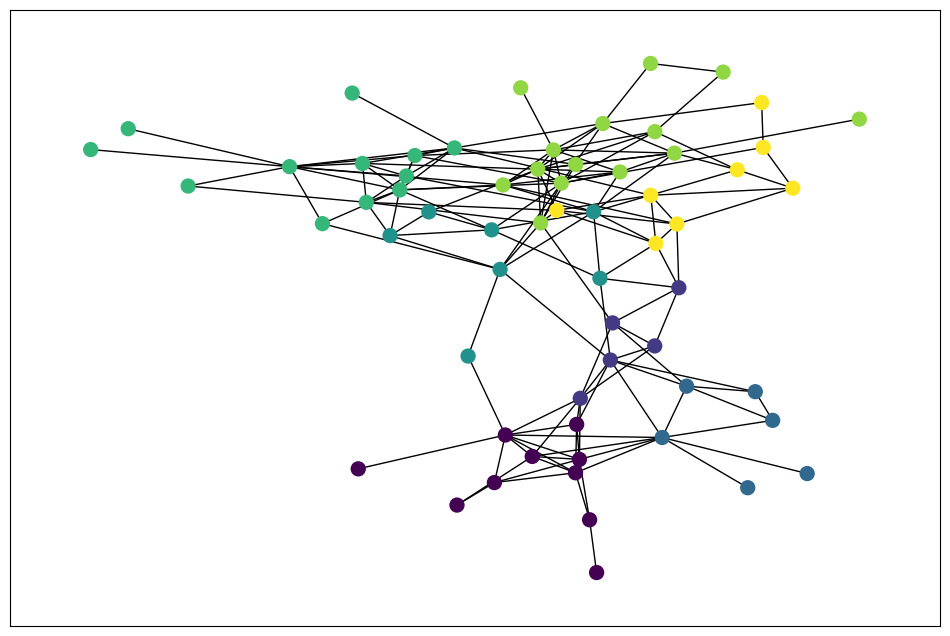

In [118]:
D2K7_labels = np.zeros(len(G))
for k, com in enumerate(grouped_labels):
    for idx in com:
        D2K7_labels[idx] = k + 1
        
D2K7_results["async_fluid"] = np.array([int(i) for i in D2K7_labels])
plot_graph(D2K7_adj, D2K7_labels)

In [116]:
D2K7_df = pd.DataFrame({"x": range(1, len(G) + 1), "y": D2K7_results["async_fluid"]})
D2K7_df.head()
D2K7_df.to_csv("results/D2-K=7.csv", header=False, index=False)

### <span style='font-family:Georgia'> D2-UNC

In [124]:
D2UNC_results = {}

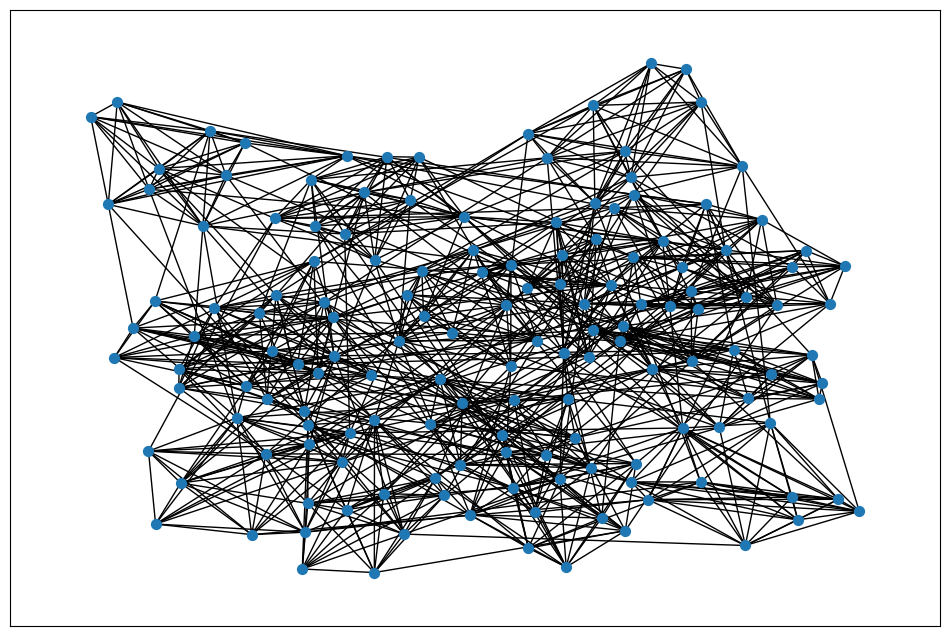

In [120]:
D2UNC_adj = generate_adjacency(D2UNC)
plot_graph(D2UNC_adj)

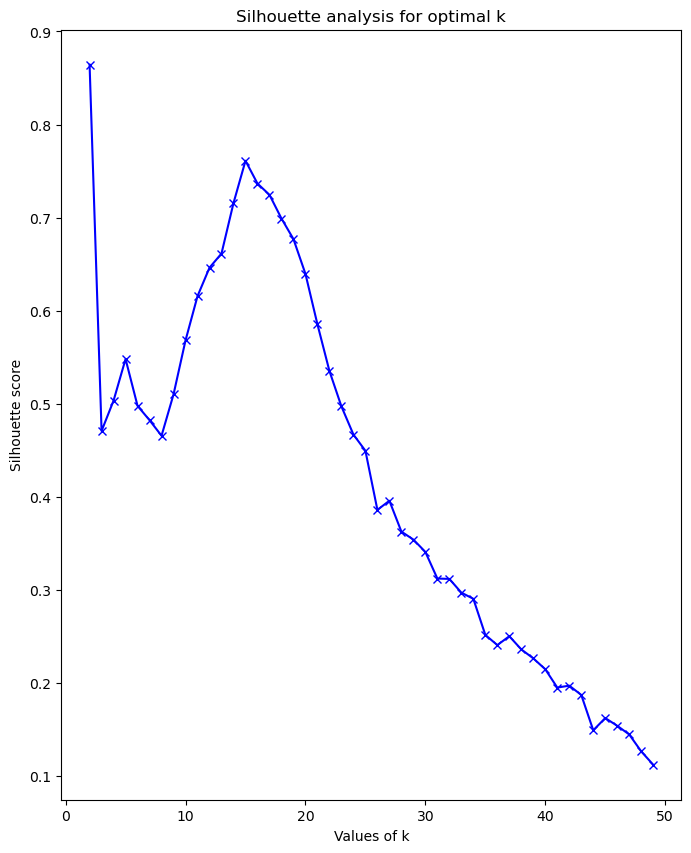

array([ 2, 15, 16, 17, 14])

In [121]:
find_optimal_k(D2UNC_adj, 50, 5)

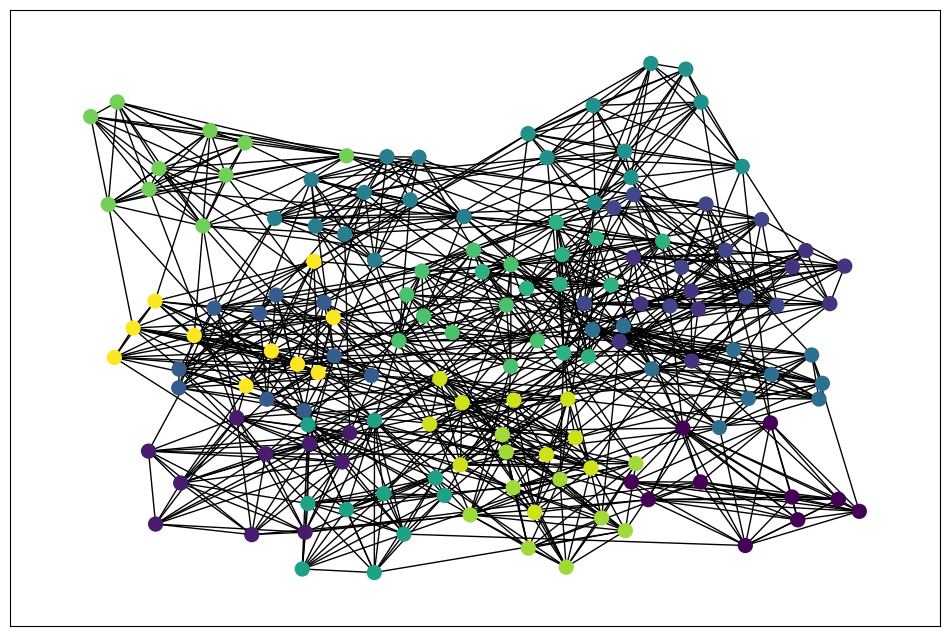

In [125]:
K = 15
D2UNC_labels = detect_communities(D2UNC_adj, K)
D2UNC_results["laplace"] = D1UNC_labels + 1
plot_graph(D2UNC_adj, D2UNC_labels)

### <span style='font-family:Georgia'> D3-K=12

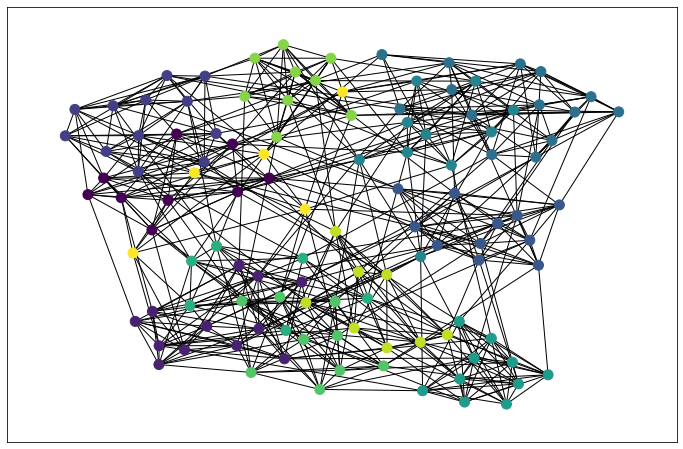

In [16]:
D3K12_adj = generate_adjacency(D3K12)
D3K12_labels = detect_communities(D3K12_adj, 12)
plot_graph(D3K12_adj, D3K12_labels)

### <span style='font-family:Georgia'> D3-UNC

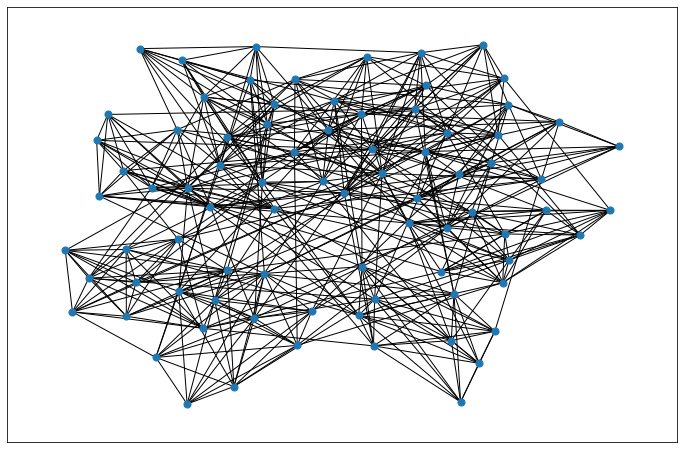

In [17]:
D3UNC_adj = generate_adjacency(D3UNC)
plot_graph(D3UNC_adj)

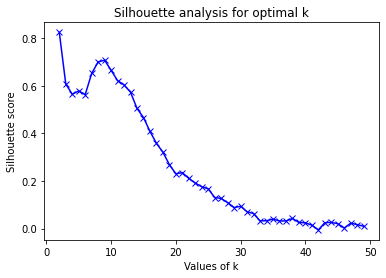

array([ 2,  9,  8, 10,  7], dtype=int64)

In [18]:
find_optimal_k(D3UNC_adj, 50, 5)

In [19]:
D3UNC_labels = detect_communities(D3UNC_adj, 9)

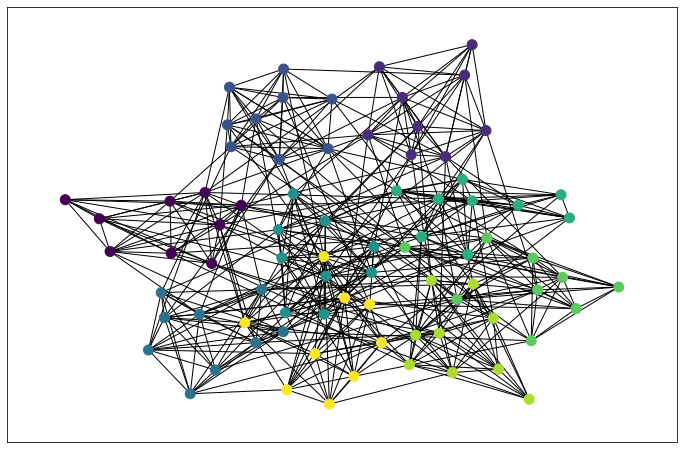

In [20]:
plot_graph(D3UNC_adj, D3UNC_labels)